In [88]:
import numpy as np
#import pytorch as pt
from scipy.sparse import diags, lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt 


delta_t = 0.01 #time step
eta = 1 # 0.1
M = 1 
#gamma = 0.05
epsilon = 1 # 0.04
Re = 1 
rho = 1/Re
m = 8 #grid point
x_0, x_m = 0, 1
y_0, y_m = 0, 1
h = (x_m - x_0) / m 

t_e = 10 
T = 100
C0 = 0 
#M = 1

x, delta_x = np.linspace(x_0, x_m, m+1, retstep = True)
y, delta_y = np.linspace(y_0, y_m, m+1, retstep = True)
X, Y = np.meshgrid(x[1:m], y[1:m], indexing = 'ij')

#process x and y to fit to representing 2D grid points
x_mod = np.zeros((m-1)**2)
y_mod = y[1:m]
for i in range(m-2):
    x_mod[i*m : i*m+m] = x[i+1]
    y_mod = np.vstack((y_mod, y[1:m])) 
y_mod = y_mod.flatten()
#print(x_mod.shape, y_mod.shape)

In [89]:
#initial condition for phi
def phi_init(x, y):
#input x and y should be meshgrid X and Y
    #phi =\
    #0.24*np.cos(np.pi*x)*np.cos(2*np.pi*y)+0.4*np.cos(np.pi*x)\
    #*np.cos(3*np.pi*y)
    #phi = 0.05*np.sin(2*np.pi*x)*np.sin(2*np.pi*y)
    #phi = np.tanh(1/(np.sqrt(2)*epsilon)*(0.25 - np.sqrt((x-0.5)**2 + \
    #(y-0.5)**2)))
    phi = 0.25 + 0.4*np.random.rand(len(x))
    #return phi.flatten()
    return phi

#initial condition for u
def u_init(x, y):
    u1 = -np.sin(np.pi*x)**2*(np.sin(2*np.pi*y))
    #u1 = np.zeros(len(x))
    #u1 = 10*x*y

    u2 = np.sin(np.pi*y)**2*(np.sin(2*np.pi*x))
    #u2 = np.zeros(len(y))
    #u2 = -10*x*y

    u = np.vstack((u1, u2))
    return u

#function to calculate f_0
def f_0(phi, epsilon):
    return 1./(4*epsilon**2) * (1-phi**2)**2

#function to calculate f_0^prime
def f_0_prime(phi, epsilon):
    return -(1-phi**2)*phi/epsilon**2
#function to calculate energy E
def E(phi, m, h):
    #gradient of phi wrt x
    gradx_phi = gradient_mat(m, h,np.ones((m**2, 1)), 1, 'x').dot(phi)
    #gradient of phi wrt y
    grady_phi = gradient_mat(m,h,np.ones((m**2, 1)), 1, 'y').dot(phi)
    #square of norm of grad phi
    norm_grad_phi = (np.square(gradx_phi) + np.square(grady_phi))*1/2
    f0 = f_0(phi, epsilon)
    #integrand
    integrand = f0 + norm_grad_phi
    #perform integration
    w_B = 0.5*h*h #boundary values' weight
    w = h*h #weight of inner grids' value
    w_C = 0.25*h*h #corner values' weight
    integral = 0
    for i in range(m**2):
        if i == 0 or i == m-1 or i == m**2-m or i == m**2-1:
            integral += integrand[i] * w_C
        elif i < m or i > m**2-m or i % m == 0 or i % m == m-1:
            integral += integrand[i] * w_B
        else:
            integral += integrand[i] * w
    return integral

#function to calculate the initial value of mu
def mu_init(m, phi, epsilon):
    #print(poisson_des(m, h, -1).shape)
    #print(phi.shape)
    #print(poisson_des(m, h, -epsilon**2).shape, phi.shape)
    poisson_term = poisson_des(m, h, -epsilon**2).dot(phi)

    nonlinear_term = f_0_prime(phi, epsilon)
    return poisson_term + nonlinear_term


In [90]:
#function to calculate initial pressure term
def p_init(u, phi, mu, eta, rho, m, h):#TODO
    #LHS-grad p
    grad = poisson_des(m, h, 1)
    #RHS
    #terms involving u
    convection_u1 = gradient_mat(m, h, u[0,:], 1, 'x').dot(u[0,:]) + \
            gradient_mat(m, h, u[1,:], 1, 'y').dot(u[0,:])
    convection_u2 = gradient_mat(m, h, u[0,:], 1, 'x').dot(u[1,:]) + \
            gradient_mat(m, h, u[1,:], 1, 'y').dot(u[1,:])
    convection_u = np.vstack((convection_u1, convection_u2))
    div_convection = div_val(m, h, convection_u, -rho)
    #print("div_convection:", div_convection)

    poisson_u1 = poisson_des(m, h, 1).dot(u[0,:])
    poisson_u2 = poisson_des(m, h, 1).dot(u[1,:])
    poisson_u = np.vstack((poisson_u1, poisson_u2))
    #print("Poisson_u:", poisson_u.shape)
    div_poisson = div_val(m, h, poisson_u, eta)
    #print("div_poisson:", div_poisson.shape)

    #terms involving phi and mu
    grad_phi_x = gradient_mat(m, h, np.ones(m**2), -1, 'x').dot(phi)
    grad_phi_y = gradient_mat(m, h, np.ones(m**2), -1, 'y').dot(phi)
    #print(grad_phi_x.shape)#TODO
    grad_mu_x = gradient_mat(m, h, grad_phi_x, 1, 'x').dot(mu)
    grad_mu_y = gradient_mat(m, h, grad_phi_y, 1, 'y').dot(mu)
    grad_mu_term = grad_mu_x + grad_mu_y
    poisson_mu = poisson_des(m, h, -1).dot(mu) * phi

    RHS = poisson_mu + grad_mu_term + div_convection + div_poisson
    #solve for p_initial
    p = spsolve(grad, RHS)
    return p


In [91]:
#poisson space descretization(dirichlet BC)
def poisson_des(m, h, s):
    laplacian = lil_matrix((m**2, m**2))
    laplacian.setdiag(-4*np.ones(m**2)/(h**2))
    for i in range(m**2):
        if i % m != 0:
            laplacian[i,i-1] = 1/(h**2) * s
        if (i+1) % m != 0:
            laplacian[i, i+1] = 1/(h**2) * s
    for i in range(m**2 - m):
        laplacian[i, i+m] = 1/(h**2) * s
        laplacian[i+m, i] = 1/(h**2) * s
    return laplacian.tocsr()

#poisson space descretization (periodic BC)
def poisson_des_p(m, h, s):
    laplacian = poisson_des(m, h, s)
    for i in range(m):
        laplacian[i, m*(m-1)+i] = s/(h**2)
        laplacian[m*(m-1)+i, i] = s/(h**2)
    #connect the first and the last columns
    for i in range(m):
        laplacian[i*m, (i+1)*m-1] = s/(h**2)
        laplacian[(i+1)*m-1, i*m] = s/(h**2)
    return laplacian

#poisson space descretization (Neumann BC)
def poisson_des_n(m, h, s):
    laplacian = poisson_des(m, h, s)
    for i in range(m):
        laplacian[i, i] += s/(h**2)
        laplacian[-(i+1), -(i+1)] += s/(h**2) #last row
        laplacian[i*m, i*m] += s/(h**2) #first column
        laplacian[(i+1)*m-1, (i+1)*m-1] += s/(h**2) #last column
    return laplacian


In [92]:
#function to build gradient matrix and also deal with the convection term
def gradient_mat(m, h, u, s, x_or_y):
#u is the first operand of the convection term (u,grad(x)), u size m**2x1
#u is a vector for the inner product with the gradient matrix
#s is a scalar to be multiplied to the gradient matrix
#x_or_y indicate it's gradient wrt x or wrt y
    if (x_or_y == 'x'):
    #x-component of gradient (gradient along x)
        grad = lil_matrix((m**2, m**2))
        for i in range(m):
            for j in range(m-2):
                grad[i*m+j+1, i*m+j] = -s/(2*h) * u[i*m+j+1]
                grad[i*m+j+1, i*m+j+2] = s/(2*h) * u[i*m+j+1]
        for i in range(m):
            grad[i*m, i*m] = -3*s/(2*h) * u[i*m]
            grad[i*m, i*m+1] = 4*s/(2*h) * u[i*m]
            grad[i*m, i*m+2] = -s/(2*h) * u[i*m]
            grad[(i+1)*m-1, (i+1)*m-1] = 3*s/(2*h) * u[(i+1)*m-1]
            grad[(i+1)*m-1, (i+1)*m-2] = -4*s/(2*h) * u[(i+1)*m-1]
            grad[(i+1)*m-1, (i+1)*m-3] = s/(2*h) * u[(i+1)*m-1]
        return grad.tocsr()
    else:
    #y-component of gradient (gradient along y)
        grad = lil_matrix((m**2, m**2))
        #first and last row of grid points
        for i in range(m):
            #first row
            grad[i, i] = -3*s/(2*h) * u[i]
            grad[i, m+i] = 4*s/(2*h) * u[i]
            grad[i, 2*m+i] = -s/(2*h) * u[i]
            #last row
            grad[m*m-1-i, m*m-1-i] = 3*s/(2*h) * u[m*m-1-i]
            grad[m*m-1-i, m*m-1-i-m] = -4*s/(2*h) * u[m*m-1-i]
            grad[m*m-1-i, m*m-1-i-2*m] = s/(2*h) * u[m*m-1-i]
        #middle rows of grid points
        #middle rows of grid points
        for i in range((m-2)*m):
            grad[i+m, i] = -s/(2*h) * u[i+m]
            grad[i+m, i+2*m] = s/(2*h) * u[i+m]
        return grad.tocsr()

In [93]:
#function to generate scalar multiply matrix
def scalar_mul(s, m):
#s is the scalar, m is the size
    scalar = lil_matrix((m**2, m**2))
    for i in range(0, m**2):
        scalar[i, i] = s
    #return csr_matrix(scalar)
    return scalar#TODO

#function for calculating divergence
#u is a vector with 2 components (2D array)
def div_val(m, h, u, s):
    div_x = gradient_mat(m, h, np.ones(m**2), s, 'x')
    div_y = gradient_mat(m, h, np.ones(m**2), s, 'y')
    div = div_x.dot(u[0,:]) + div_y.dot(u[1,:])
    return div

def biharmonic(m, h, s):
    bh = lil_matrix((m**2, m**2))
    bh.setdiag(20*np.ones(m**2)/(h**4))
    for i in range(m**2):
        if i % m != 0:
            bh[i, i-1] = -8/(h**4) * s
            if i % m != 1: #not the second column
                bh[i, i-2] = 1/(h**4) * s #u_{i,j-2}
        if (i+1) % m != 0:
            bh[i, i+1] = -8/(h**4) * s
            if (i+2) % m != 0: #not the second last column
                bh[i, i+2] = 1/(h**4) * s #u_{i,j+2}
    for i in range(m**2 - m):
        bh[i, i+m] = -8/(h**4) * s #u_{i+1,j}
        bh[i+m, i] = -8/(h**4) * s #u_{i-1,j}
    for i in range(m**2 -m -1):
        if (i+1) % m != 0: #not the last column
            bh[i, i+m+1] = 2/(h**4) * s #u_{i+1,j+1}
        #if (i+m+1) % m != 0: #not the first column
            bh[i+m+1, i] = 2/(h**4) * s #u_{i-1,j-1}
    for i in range(m**2-m+1):
        if i % m != 0:
            bh[i+m-1, i] = 2/(h**4) * s #u_{i-1,j+1}
            bh[i, i+m-1] = 2/(h**4) * s #u_{i+1,j-1}
    for i in range(m**2-2*m):
        bh[i, i+2*m] = 1/(h**4) * s #u_{i+2,j}
        bh[i+2*m, i] = 1/(h**4) * s #u_{i-2,j}
    #Neumann BC
    for i in range(m):
        bh[i,i] -= 8/(h**4) * s #-8u_{i-1,j}
        bh[-(i+1), -(i+1)] -= 8/(h**4) * s #-8u_{i+1, j}
        bh[i,i] += 1/(h**4) * s #u_{i-2,j} for first row
        bh[-(i+1), -(i+1)] += 1/(h**4) * s #u_{i+2,j} for last row
        bh[m+i,i] += 1/(h**4) * s #u_{i-2,j} for the second row
        bh[-(i+1+m),-(i+1)] += 1/(h**4) * s #u_{i+2,j} for the 2nd last row
        if i != m-1:
            bh[-(i+1),-(i+2)] += 2/(h**4) * s #2u_{i+1,j-1}
            bh[i,i+1] += 2/(h**4) * s #2u_{i-1,j+1}
        else:
            bh[-(i+1),-(i+1)] += 2/(h**4) * s #2u_{i+1,j-1}
            bh[i,i] += 2/(h**4) * s #2u_{i-1.j+1}
        if i != 0:
            bh[-(i+1),-i] += 2/(h**4) * s #2u_{i+1,j+1} for last row
            bh[i,i-1] += 2/(h**4) * s #2u_{i-1,j-1}
        else:
            bh[-(i+1),-(i+1)] += 2/(h**4) * s #2u_{i+1,j+1} for last entry
            bh[i,i] += 2/(h**4) * s #2u_{i-1,j-1} for 1st entry
    #columns
    for i in range(m):
        bh[(i+1)*m-1,(i+1)*m-1] -= 8/(h**4) * s #-8u_{i,j+1} for last col
        bh[i*m,i*m] -= 8/(h**4) * s #-8u_{i,j-1} for first col
        bh[(i+1)*m-1,(i+1)*m-1] += 1/(h**4) * s #u_{i,j+2} for last col
        bh[i*m,i*m] += 1/(h**4) * s #u_{i,j-2} for first col
        bh[(i+1)*m-2,(i+1)*m-1] += 1/(h**4) * s #u_{i,j+2} for 2nd last col
        bh[i*m+1,i*m] += 1/(h**4) * s #u_{i,j-2} for 2nd first col
    #plt.spy(bh)
    #plt.show()
    return bh.tocsr()


In [94]:
#function to calculate extrapolation
def extrap(a_n, a_n1):
    return 2*a_n - a_n1

#first step: solve for u_hat with NS equation (helper function to
#solve_full_u_hat)
#dim specifies to solve for u1 or u2
def solve_u_hat(u_n, u_n_minus, p_n, p_n_minus, phi_n, phi_n_minus, delta_t,\
rho, eta, m, dim):
    #building LHS
    constant_coef = scalar_mul(3, m)
    #convection term on the LHS
    print("solve_u_hat:u_n shape:", u_n.shape) #TODO
    u_e = extrap(u_n, u_n_minus)
    convection_LHS = gradient_mat(m, h, u_e[0,:], 2*delta_t, 'x') + \
                    gradient_mat(m, h, u_e[1,:], 2*delta_t, 'y')
    #Laplacian term on the LHS
    s = -eta*2*delta_t / rho
    laplacian = poisson_des(m, h, s)

    LHS = constant_coef + convection_LHS + laplacian

    #building RHS
    ind = 0 if dim == 1 else 1 #index for column for u_n and u_n_minus
    linear_term = scalar_mul(4, m).dot(u_n[ind,:]) - u_n_minus[ind,:]
    #convection_term = gradient_mat(m, h, u_n[0,:], -delta_t, 'x').dot(\
    #           u_n_minus[ind,:])\
    #           + gradient_mat(m, h, u_n[1,:], -delta_t, 'y').dot(\
    #           u_n_minus[ind,:])
    #convection_term *= delta_t
    #Laplacian term
    #s2 = delta_t*eta/rho #scalar for poisson for u_n_minus
    #laplacian_term = poisson_des(m, h, s2).dot(u_n_minus[ind,:])
    #gradient term for mu and p
    phi_e = extrap(phi_n, phi_n_minus)
    mu = helper_mu(m, h, phi_e, epsilon, C0)
    x_or_y = 'x' if dim == 1 else 'y'
    p_s = -2*delta_t/rho
    p_e = extrap(p_n, p_n_minus)
    gradient_term = gradient_mat(m, h, np.ones(m**2), p_s, x_or_y)\
            .dot(p_e) + gradient_mat(m, h, phi_e, p_s, x_or_y).dot(mu)

    RHS = linear_term + gradient_term
    #finally, solve for u
    u_hat = spsolve(LHS, RHS)
    return u_hat

#function to get full u_hat (with two components)
def solve_full_u_hat(u_n, u_n_minus, p_n, p_n_minus, phi_n, phi_n_minus,\
delta_t, rho, eta, m):
    u1 = solve_u_hat(u_n, u_n_minus, p_n, p_n_minus, phi_n, phi_n_minus,\
    delta_t, rho, eta, m, 1)
    u2 = solve_u_hat(u_n, u_n_minus, p_n, p_n_minus, phi_n, phi_n_minus,\
    delta_t, rho, eta, m, 2)
    u_hat = np.vstack((u1, u2))
    return u_hat

#function for solving pressure p using Helmholtz decomposition
#u is the u_hat^(n+1), p_n is the p in previous time step
def solve_p(m, h, u, delta_t, p_n):
    #RHS (divergence of u_n+1)
    RHS = div_val(m, h, u, 1)
    #LHS(laplacian of p_n+1 - p_n)
    poisson_p = poisson_des(m, h, delta_t/2)
    #solve for p_diff
    p_diff = spsolve(poisson_p, RHS)
    p = p_diff + p_n
    return p

#helper function to calculate r
def helper_r(m, h, phi_n, C0):
    r = np.sqrt(E(phi_n, m, h) + C0)
    return r

#helper function to solve b_e
#return b_e
def helper_b(m, h, phi_e, C0):
    numerator = f_0_prime(phi_e, epsilon)
    denominator = np.sqrt(E(phi_e, m, h)+C0)
    return numerator / denominator

#helper: solve Ax=(b)
def A_inverse_b(m, h, delta_t, M, epsilon, poisson_b, u):
    #LHS (A)
    scalar_ = scalar_mul(3/(2*delta_t), m)
    biharmonic_ = biharmonic(m, h, M*epsilon**2)
    #divergence u
    div_u = div_val(m, h, u, 1)
    A = scalar_ + biharmonic_ + div_u
    #solve for A_inverse_poisson_b
    result = spsolve(A, poisson_b)
    return result

#helper: calculate gamma = -<A^-1 Laplacian(b), b>
#in order to later calculate <bn,phi_n_plus>
def gamma(m, h, delta_t, M, epsilon, b, u):
    poisson_b = poisson_des_n(m, h, 1).dot(b) #b use neumann BC
    A_term = A_inverse_b(m, h, delta_t, M, epsilon, poisson_b, u)
    return -M/2 * np.dot(A_term, b)

#helper: compute <b, phi_n+1>, it will also return A^-1*g
def b_phi_inner_product(m, h, delta_t, M, epsilon, u, phi_n,\
                        phi_n_minus, b, C0):
    #RHS (g_term)
    # scalar phi term
    scalar_phi = -phi_n_minus/(2*delta_t) + 4*phi_n/(2*delta_t)
    # laplacian b term
    r_n = helper_r(m, h, phi_n, C0)
    r_minus = helper_r(m, h, phi_n_minus, C0)
    laplacian_b_coef = M*(4/3*r_n + 1/6*(np.dot(b,(-4*phi_n+phi_n_minus))) \
        - 1/3*r_minus)
    #print("lb",laplacian_b_coef)
    laplacian_b = poisson_des_n(m, h, laplacian_b_coef).dot(b)

    g = scalar_phi + laplacian_b
    A_inverse_g = A_inverse_b(m, h, delta_t, M, epsilon, g, u)

    RHS = np.dot(A_inverse_g, b)
    #LHS
    LHS = 1 + gamma(m, h, delta_t, M, epsilon, b, u)

    result = RHS/LHS
    return result, A_inverse_g

#helper: calculate mu for a certain time step
def helper_mu(m, h, phi, epsilon, C0):
    poisson_phi = poisson_des_n(m, h, -epsilon**2).dot(phi)
    r = helper_r(m, h, phi, C0)
    f_term = r * helper_b(m, h, phi, C0)
    return poisson_phi + f_term

#function to solve phi after solving u_n+1
#This function is using u_hat as u_n+1 and not the real u_n+1 when
#solving for phi. TODO
def solve_phi(m, h, delta_t, M, epsilon, u, phi_n,\
            phi_n_minus, b, C0):
    #RHS
    b_phi_ip, RHS_2 = b_phi_inner_product(m, h, delta_t, M, \
        epsilon, u, phi_n, phi_n_minus, b, C0)

    first_term_coef = M/2 * b_phi_ip
    poisson_b = poisson_des_n(m, h, first_term_coef).dot(b)
    RHS_1 = A_inverse_b(m, h, delta_t, M, epsilon, poisson_b, u)
    RHS = RHS_1 + RHS_2
    return RHS #phi_n+1 equals RHS


In [95]:
#this function calculate the real u_n+1
def solve_real_u(m, h, u_hat, p_n, p_n_plus, delta_t):
    p_diff = p_n_plus - p_n
    grad_p_diff_x = gradient_mat(m, h, np.ones(m**2), delta_t/2, 'x')\
                .dot(p_diff)
    grad_p_diff_y = gradient_mat(m, h, np.ones(m**2), delta_t/2, 'y')\
                .dot(p_diff)
    u_real_x = u_hat[0,:] + grad_p_diff_x
    u_real_y = u_hat[1,:] + grad_p_diff_y
    u_real = np.vstack((u_real_x, u_real_y))
    return u_real

#The code below will officially begin iterating through time

def Euler_one_step_helper_u(m, h, delta_t, M, u_n, p, phi, rho, eta, \
                epsilon, C0, dim):
    #building LHS
    constant_coef = scalar_mul(1, m)
    convection_LHS = gradient_mat(m, h, u_n[0,:], delta_t, 'x') + \
                    gradient_mat(m, h, u_n[1,:], delta_t, 'y')
    #Laplacian term on the LHS
    s = -eta*delta_t / rho
    laplacian = poisson_des(m, h, s)
    LHS = constant_coef + convection_LHS + laplacian

    #building RHS
    ind = 0 if dim == 1 else 1 #index for column for u_n and u_n_minus
    linear_term = u_n[ind,:]
    #gradient term for mu and p
    mu = helper_mu(m, h, phi, epsilon, C0)
    x_or_y = 'x' if dim == 1 else 'y'
    p_s = -delta_t/rho
    gradient_term = gradient_mat(m, h, np.ones(m**2), p_s, x_or_y)\
            .dot(p) + gradient_mat(m, h, phi, p_s, x_or_y).dot(mu)

    RHS = linear_term + gradient_term
    #finally, solve for u
    u_hat = spsolve(LHS, RHS)
    return u_hat

def Euler_one_step_helper_phi(m, h, delta_t, M, epsilon, u, phi, b, C0):
#This u should be u_n+1 calculated from previous steps
    #RHS (g_term)
    # laplacian b term
    r_n = helper_r(m, h, phi, C0)
    laplacian_b_coef = M*(1/2*(np.dot(phi, b)) + r_n)
    laplacian_b = poisson_des_n(m, h, laplacian_b_coef).dot(b)

    g = laplacian_b
    #calculating A_inverse_g
    scalar_ = scalar_mul(1/delta_t, m)
    biharmonic_ = biharmonic(m, h, M*epsilon**2)
    #divergence u
    div_u = div_val(m, h, u, 1)
    A = scalar_ + biharmonic_ + div_u
    #solve for A_inverse_g
    A_inverse_g = spsolve(A, g)

    RHS = A_inverse_g * b
    #LHS
    poisson_b = poisson_des_n(m, h, 1).dot(b) #b use neumann BC
    #solve for A_inverse_delta_b
    A_inverse_delta_b = spsolve(A, poisson_b)

    #LHS ceof
    LHS = 1 - M * np.dot(A_inverse_delta_b, b) /2
    b_phi_ip = RHS/LHS
    phi_n_plus = M * A_inverse_delta_b/2 * b_phi_ip + A_inverse_g
    return phi_n_plus

#calculate u, phi, p for the first few time steps
#this delta_t is the delta_t for the first few steps using Euler method
def Euler_one_step(m, h, delta_t, M, u_n, p, phi, rho, eta, \
                epsilon, C0):
    u_hat_1 = Euler_one_step_helper_u(m, h, delta_t, M, u_n, p, phi, rho,\
                eta, epsilon, C0, 1)
    u_hat_2 = Euler_one_step_helper_u(m, h, delta_t, M, u_n, p, phi, rho,\
                eta, epsilon, C0, 2)
    u_hat = np.vstack((u_hat_1, u_hat_2))
    # solve for p
    p_n = p
    p = solve_p(m, h, u_hat, delta_t, p_n) #this is p_n+1
    # solve for real u_n+1
    u = solve_real_u(m, h, u_hat, p_n, p, delta_t) #this is u_n+1

    # solve for phi with u_n+1
    b_n = helper_b(m, h, phi, C0)
    phi_plus = Euler_one_step_helper_phi(m, h, delta_t, M, epsilon,\
        u, phi, b_n, C0)
    return u, p, phi_plus

#calculate u, phi, p for the time step using BDF2
def BDF2_one_step(m, h, delta_t, M, u_n, u_n_minus, p_n, p_n_minus,\
            phi_n, phi_n_minus, rho, eta, epsilon, C0):
    # solve for u_hat
    u_hat_1 = solve_u_hat(u_n, u_n_minus, p_n, p_n_minus, phi_n,\
        phi_n_minus, delta_t, rho, eta, m, 1)
    u_hat_2 = solve_u_hat(u_n, u_n_minus, p_n, p_n_minus, phi_n,\
        phi_n_minus, delta_t, rho, eta, m, 2)
    u_hat = np.vstack((u_hat_1, u_hat_2))

    # solve for p
    p = solve_p(m, h, u_hat, delta_t, p_n) #this is p_n+1
    # solve for real u_n+1
    print("u_hat shape", u_hat.shape)
    u = solve_real_u(m, h, u_hat, p_n, p, delta_t) #this is u_n+1

    # solve for phi with u_hat
    # first, calculate b_n and r
    phi_e = extrap(phi_n, phi_n_minus)
    b_e = helper_b(m, h, phi_e, C0)
    # then solve for phi_n+1
    phi_n_plus = solve_phi(m, h, delta_t, M, epsilon, u, phi_n, \
                phi_n_minus, b_e, C0) #this is phi_n+1
    return u, p, phi_n_plus

#function to solve regular BDF2 time stepping
# T is the total amount of time steps
# t_e is the total amount of time steps for Euler method
def time_stepping(m, h, delta_t, t_e, T, x, y, eta, rho, epsilon, M, C0):
    #calculate the initial values
    u_init_ = u_init(x, y)
    phi_init_ = phi_init(x, y)
    mu_init_ = mu_init(m, phi_init_, epsilon)
    p_init_ = p_init(u_init_, phi_init_, mu_init_, eta, rho, m, h)
    # changing the initial pressure TODO
    #p_init_ = np.zeros(m**2)

    #start time stepping
    #first do Euler time stepping 10 times
    delta_t_euler = delta_t / t_e
    u_n_minus = u_init_
    u_n = u_init_
    p_n_minus = p_init_
    p_n = p_init_
    #print("p_init_;", p_init_)#TODO
    #print("u_init_", u_init_)

    phi_n_minus = phi_init_
    phi_n = phi_init_
    #print("phi_init", phi_init_)


    for i in range(t_e):
        if i == 0:
            u_n, p_n, phi_n = Euler_one_step(m, h, delta_t_euler, M, \
                    u_n_minus, p_n, phi_n_minus, rho, eta, epsilon, C0)
            continue
        print("i: ", i)#TODO
        print("u_n shape:", u_n.shape, u_n_minus.shape)
        u, p, phi = BDF2_one_step(m, h, delta_t_euler, M, \
                u_n, u_n_minus, p_n, p_n_minus, phi_n, phi_n_minus, rho,eta,\
                epsilon, C0)

        #update n_minus and n variables
        p_n_minus = p_n
        p_n = p
        u_n_minus = u_n
        phi_n_minus = phi_n
        u_n = u
        phi_n = phi

        u_norm = np.sqrt(u[0,:]**2, u[1,:]**2)

        #X, Y = np.meshgrid(x, y, indexing = 'ij')
        u_norm = np.reshape(u_norm, (m, m))
        plt.contourf(X, Y, u_norm)
        plt.axis('scaled')
        plt.title(f"u {i}")
        plt.colorbar()
        plt.show()

        phi_plot = np.reshape(phi, (m,m))
        plt.contourf(X, Y, phi_plot)
        plt.axis('scaled')
        plt.title(f"phi {i}")
        plt.colorbar()
        plt.show()
        print("u_n vector:", u_n)

    
    for i in range(T):
        print("i", i)
        if i == 0:
            u_n_minus = u_init_
            phi_n_minus = phi_init_
        u, p, phi = BDF2_one_step(m, h, delta_t, M, u_n, u_n_minus, p_n,\
                p_n_minus, phi_n, phi_n_minus, rho, eta, epsilon, C0)
        #update n_minus and n variable
        p_n_minus = p_n
        p_n = p
        u_n_minus = u_n
        phi_n_minus = phi_n
        u_n = u
        #print("u_n vetor:", u_n)
        phi_n = phi

        u_norm = np.sqrt(u[0,:]**2, u[1,:]**2)
        #X, Y = np.meshgrid(x, y, indexing = 'ij')
        u_norm = np.reshape(u_norm, (m, m))
        phi_plot = np.reshape(phi, (m, m))
        plt.contourf(X, Y, u_norm)
        plt.axis('scaled')
        plt.title(f"u {i}")
        plt.colorbar()
        plt.show()

        phi_plot = np.reshape(phi, (m,m))
        plt.contourf(X, Y, phi_plot)
        plt.axis('scaled')
        plt.title(f"phi {i}")
        plt.colorbar()
        plt.show()

    return u_n, p, phi_n


In [96]:
def plotting(m, h, delta_t, t_e, T, x, y, eta, rho, epsilon, M, C0):
    u, p, phi = time_stepping(m, h, delta_t, t_e, T, x, y, eta, \
                        rho, epsilon, M, C0)
    u_norm = np.sqrt(u[0,:]**2, u[1,:]**2)
    #X, Y = np.meshgrid(x, y, indexing = 'ij')
    u_norm = np.reshape(u_norm, (m, m))
    phi_plot = np.reshape(phi, (m, m))
    plt.contourf(X, Y, u_norm)
    plt.axis('scaled')
    plt.title('u_norm final')
    plt.colorbar()
    plt.show()

    plt.contourf(X, Y, phi_plot)
    plt.axis('scaled')
    plt.title('phi_final')
    plt.colorbar()
    plt.show()

/var/folders/r1/1z_0fp4d0jzbn22kmxqqcf3m0000gn/T/ipykernel_24138/649244484.py:57: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  A_inverse_g = spsolve(A, g)
/var/folders/r1/1z_0fp4d0jzbn22kmxqqcf3m0000gn/T/ipykernel_24138/649244484.py:63: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  A_inverse_delta_b = spsolve(A, poisson_b)
/var/folders/r1/1z_0fp4d0jzbn22kmxqqcf3m0000gn/T/ipykernel_24138/167943941.py:91: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  result = spsolve(A, poisson_b)


i:  1
u_n shape: (2, 49) (2, 49)
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


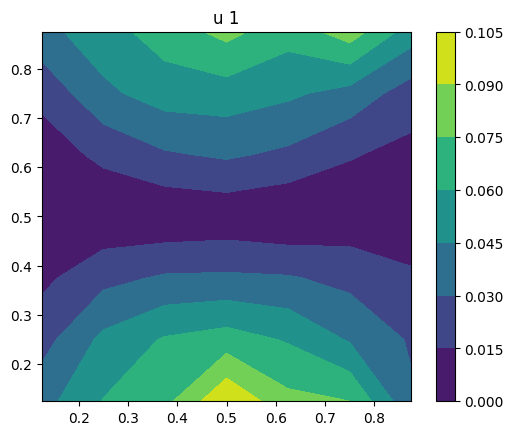

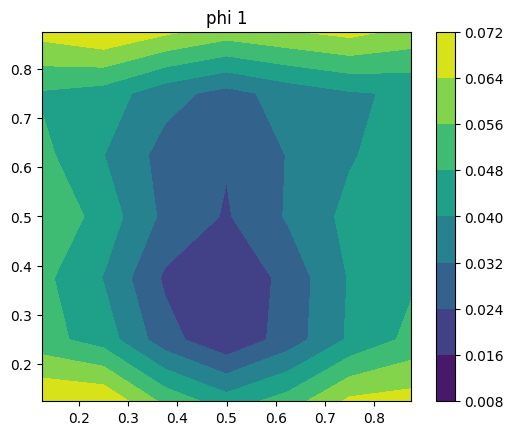

u_n vector: [[-0.03929271 -0.0242453  -0.01144999 -0.00118441  0.00740379  0.01871721
   0.0401849  -0.06062089 -0.04862012 -0.02549115 -0.00291796  0.01822495
   0.0417243   0.05343787 -0.07052194 -0.06148171 -0.03195537  0.00229827
   0.02818743  0.0517566   0.06741815 -0.10374493 -0.06682127 -0.03268171
   0.00406511  0.03203613  0.05290515  0.07946521 -0.07917158 -0.05856599
  -0.0313944   0.0006626   0.02684741  0.04765742  0.06572696 -0.07506758
  -0.04354674 -0.02547143 -0.00497234  0.01603815  0.03951263  0.08282652
  -0.03222605 -0.02814606 -0.01821692 -0.00131392  0.01068066  0.02240232
   0.05254498]
 [-0.03590543 -0.06190518 -0.08771886 -0.09480444 -0.09788191 -0.07031633
  -0.0510031  -0.02861162 -0.04403136 -0.06003467 -0.06133307 -0.05681488
  -0.0437535  -0.03132634 -0.01312564 -0.02533895 -0.02926432 -0.03051927
  -0.02194179 -0.02087215 -0.01360758  0.0033573   0.00444305  0.01017409
   0.00485383  0.00584698  0.00276238  0.00111339  0.01273377  0.02499425
   0.035167

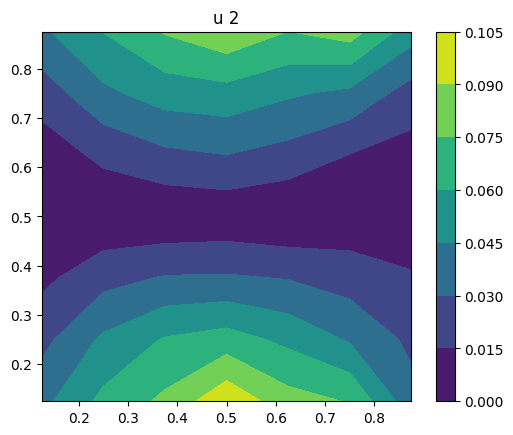

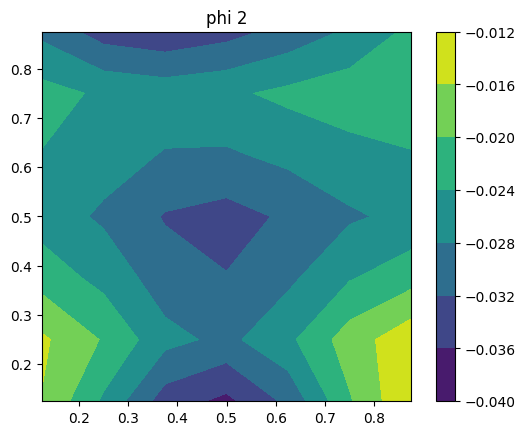

u_n vector: [[-0.04047434 -0.02552896 -0.01144109 -0.00113095  0.00681079  0.02153979
   0.042338   -0.06388905 -0.04766907 -0.02475799 -0.00290237  0.01829598
   0.04172915  0.06029984 -0.07819291 -0.06129989 -0.03126245  0.00226106
   0.02678939  0.05168968  0.07617021 -0.10174612 -0.06661146 -0.03185261
   0.00361964  0.02997768  0.05421632  0.0864512  -0.0810017  -0.05632427
  -0.02930126  0.00067627  0.02452047  0.04700863  0.07480141 -0.0740368
  -0.04346969 -0.02302057 -0.0048779   0.01465883  0.04146631  0.08181597
  -0.0353435  -0.02651771 -0.01706689 -0.00147987  0.00905635  0.02338703
   0.05167204]
 [-0.03661278 -0.06389161 -0.08957306 -0.09733816 -0.10004683 -0.07148887
  -0.0492673  -0.02692026 -0.04532567 -0.06271426 -0.06511785 -0.05932352
  -0.04517393 -0.02912836 -0.01180025 -0.02604969 -0.03070658 -0.03312417
  -0.02420114 -0.02142857 -0.01175298  0.00219998  0.00268955  0.00708688
   0.00463095  0.00555389  0.00239876  0.00089629  0.01146118  0.02417444
   0.0345208

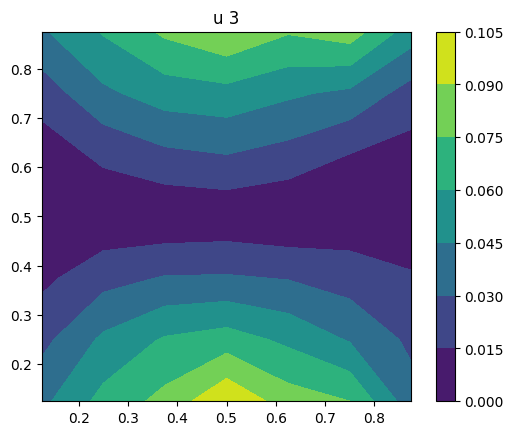

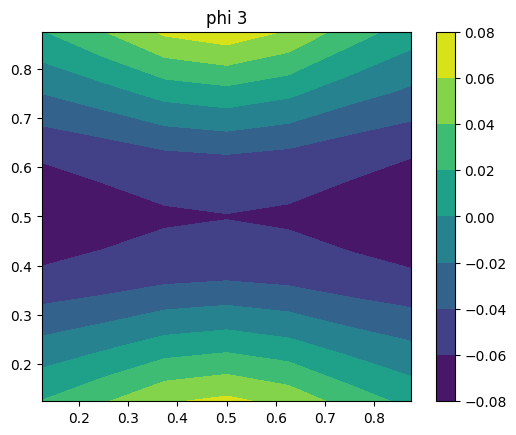

u_n vector: [[-0.04113136 -0.02561127 -0.0113135  -0.00114513  0.00667861  0.02154463
   0.04289965 -0.06493569 -0.04792688 -0.02461474 -0.00292081  0.0181141
   0.04194521  0.06126878 -0.07959444 -0.06164025 -0.03107042  0.00223462
   0.02661188  0.05210344  0.07773913 -0.10354047 -0.06698241 -0.03165261
   0.00359292  0.0298201   0.05469154  0.08833504 -0.08245276 -0.05670541
  -0.02918066  0.0006515   0.02440303  0.04742978  0.07631304 -0.07508375
  -0.04368411 -0.02293373 -0.00489169  0.01452449  0.04160734  0.08291684
  -0.03587588 -0.02666604 -0.01695329 -0.00147836  0.00894405  0.0234034
   0.05226299]
 [-0.03648269 -0.06397949 -0.0896982  -0.09742833 -0.10017607 -0.07160426
  -0.04918695 -0.0267556  -0.0453624  -0.06274552 -0.06510217 -0.05936366
  -0.04518588 -0.02885437 -0.01165352 -0.02605676 -0.03070428 -0.0330864
  -0.02418926 -0.02139816 -0.01145198  0.00221146  0.00273813  0.00715725
   0.00462825  0.00556251  0.00241525  0.00089058  0.01128764  0.02422086
   0.03457798 

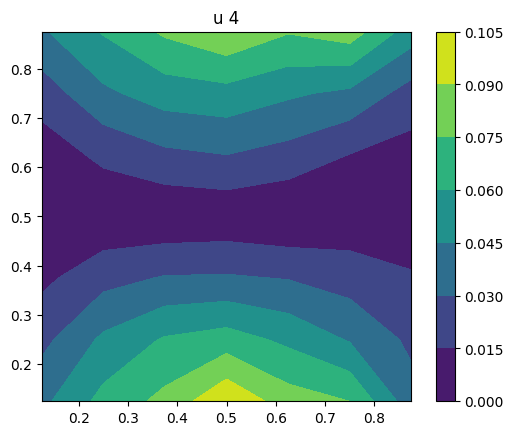

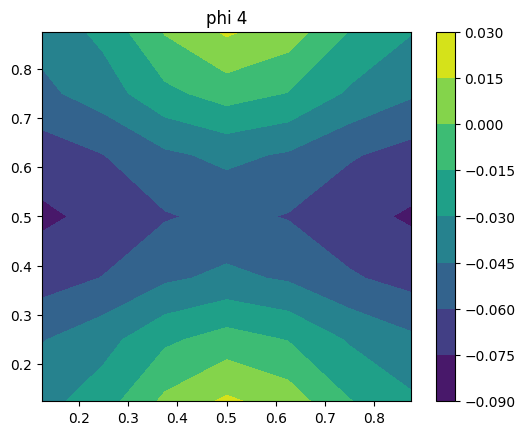

u_n vector: [[-0.04109366 -0.02567407 -0.0114316  -0.00113566  0.00681625  0.02163335
   0.04289188 -0.06480349 -0.04794313 -0.02473667 -0.00291357  0.01825839
   0.0419771   0.06116055 -0.07928854 -0.06157523 -0.03118032  0.00224045
   0.02673159  0.05203129  0.07740479 -0.10310322 -0.06687312 -0.03175084
   0.00359574  0.02992199  0.05457381  0.08788565 -0.08215422 -0.05664138
  -0.02927952  0.00065516  0.02451053  0.04737085  0.07603091 -0.07496423
  -0.04370984 -0.0230366  -0.0048883   0.01464305  0.04165526  0.08282831
  -0.03586245 -0.02671812 -0.01705484 -0.00147417  0.00905396  0.02348282
   0.05227536]
 [-0.03649728 -0.0639571  -0.08967352 -0.09741479 -0.10015711 -0.07158239
  -0.04919955 -0.0268531  -0.04536993 -0.06272895 -0.06509165 -0.05934929
  -0.04520563 -0.02898422 -0.01179132 -0.02608949 -0.03069829 -0.03308168
  -0.02418898 -0.02144154 -0.01162224  0.0022195   0.00273047  0.00714224
   0.0046258   0.00555778  0.00241339  0.00091021  0.01142707  0.02423812
   0.034556

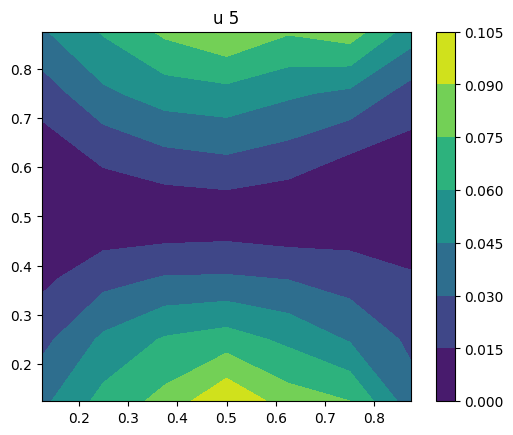

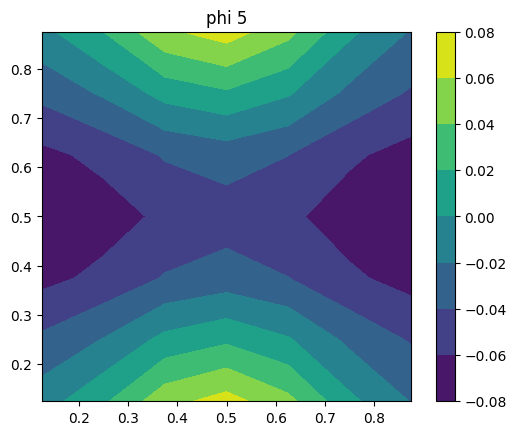

u_n vector: [[-0.04117037 -0.02561385 -0.01129297 -0.00113816  0.00666698  0.02156895
   0.04298323 -0.06503399 -0.04794197 -0.02460497 -0.00291712  0.01811564
   0.04198026  0.06142904 -0.07976353 -0.06167785 -0.03107155  0.00223694
   0.02661427  0.05215227  0.07795283 -0.10368178 -0.06702073 -0.03165483
   0.00359313  0.02981969  0.05474324  0.08854359 -0.08258665 -0.05672808
  -0.02917363  0.00065362  0.02439905  0.04746876  0.07651244 -0.07516066
  -0.04370187 -0.02291895 -0.00488837  0.01452172  0.04164878  0.08304237
  -0.03592564 -0.02666434 -0.01693862 -0.00147283  0.00893648  0.02342791
   0.05234395]
 [-0.03642512 -0.06395626 -0.08969085 -0.09743242 -0.10017718 -0.07158263
  -0.0491176  -0.0266755  -0.045335   -0.06274129 -0.06510968 -0.0593624
  -0.04516564 -0.02878118 -0.01161484 -0.02604679 -0.03070281 -0.03309308
  -0.02419247 -0.02139208 -0.01142227  0.00219868  0.0027293   0.00714677
   0.00462935  0.00556317  0.0024115   0.00087941  0.01124817  0.02420509
   0.0345693

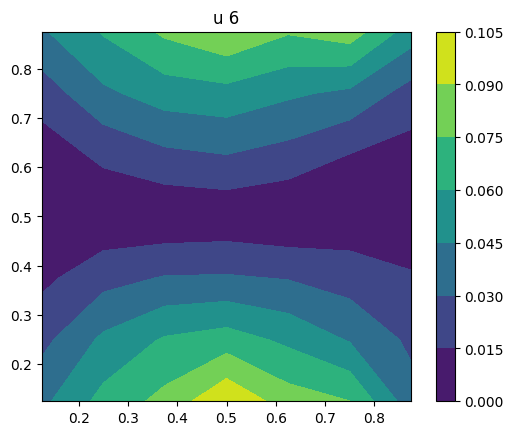

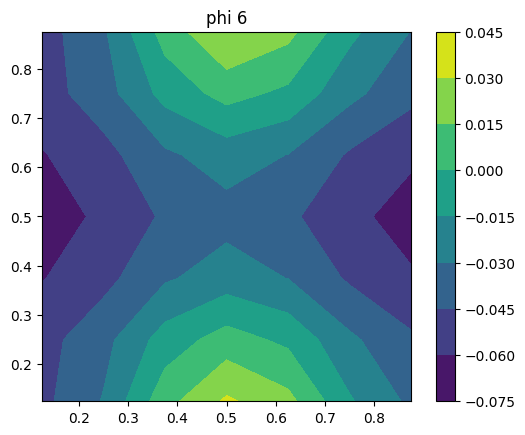

u_n vector: [[-0.04120505 -0.02566155 -0.01134283 -0.00113358  0.00672624  0.0216204
   0.04301552 -0.06499257 -0.04795681 -0.02465002 -0.00291306  0.01816859
   0.04199486  0.06137704 -0.07956575 -0.06162106 -0.03109749  0.00223967
   0.026645    0.05209057  0.07773583 -0.10342375 -0.0669342  -0.03166911
   0.00359469  0.02983719  0.05465372  0.08827228 -0.08244003 -0.05668908
  -0.02919549  0.00065428  0.02442334  0.04743107  0.07636434 -0.07514912
  -0.04371892 -0.0229487  -0.0048886   0.01455222  0.0416675   0.08303282
  -0.03595803 -0.02669635 -0.01696578 -0.00147362  0.00896301  0.02346025
   0.05237681]
 [-0.03645213 -0.06395467 -0.08968302 -0.09742582 -0.10016943 -0.07158253
  -0.04915044 -0.02679312 -0.0453656  -0.06274093 -0.06510572 -0.05936375
  -0.04520157 -0.0289117  -0.01174402 -0.02608768 -0.03070917 -0.03309368
  -0.02420067 -0.02143615 -0.01155581  0.00222664  0.00273291  0.00714377
   0.00462687  0.00555903  0.00241604  0.00091643  0.01137603  0.02423505
   0.0345673

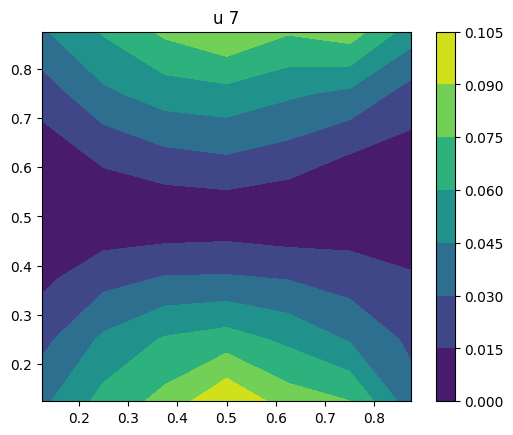

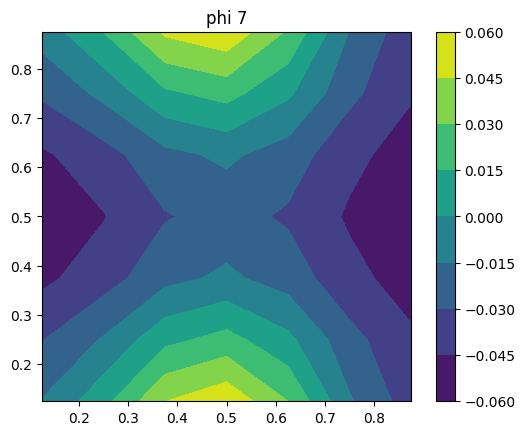

u_n vector: [[-0.04115787 -0.02559823 -0.0112786  -0.00113778  0.00665318  0.02155207
   0.04296712 -0.06503178 -0.04793305 -0.02459394 -0.00291645  0.01810588
   0.04197123  0.06142592 -0.07977046 -0.06167477 -0.03106288  0.00223792
   0.02660767  0.05215095  0.07796371 -0.10368617 -0.0670165  -0.03164572
   0.00359414  0.02981273  0.05474125  0.08855389 -0.08259338 -0.05672409
  -0.0291647   0.00065446  0.02439193  0.04746655  0.07652413 -0.07517554
  -0.043701   -0.02291082 -0.00488764  0.01451546  0.04165009  0.08306182
  -0.03593981 -0.02666284 -0.01692958 -0.00147219  0.00892932  0.02342889
   0.05236205]
 [-0.03641695 -0.06395444 -0.08969398 -0.09743706 -0.10017992 -0.07158003
  -0.04910797 -0.02666469 -0.04533472 -0.06274761 -0.0651177  -0.05936812
  -0.04516345 -0.02876507 -0.01161866 -0.0260526  -0.03071044 -0.03310123
  -0.02419976 -0.02139666 -0.01142213  0.00219391  0.00272718  0.00714618
   0.00462907  0.00556239  0.00240878  0.00087365  0.01126134  0.024214
   0.03457761

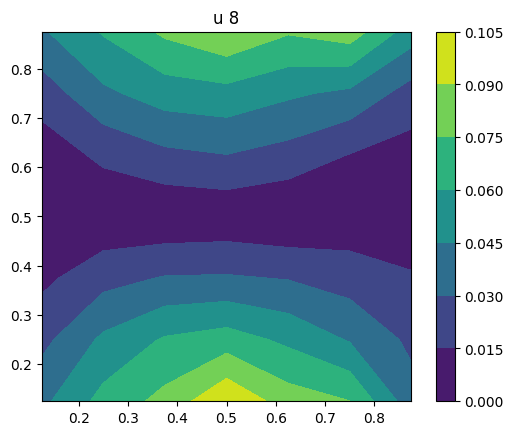

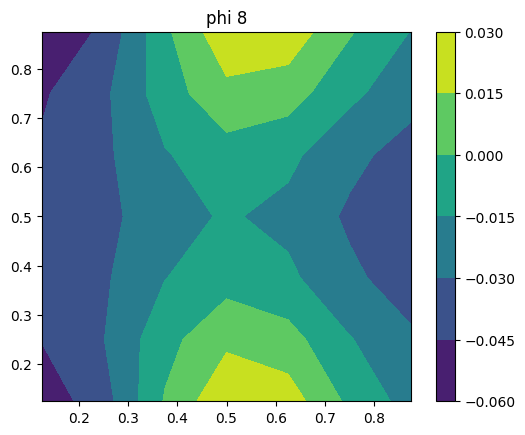

u_n vector: [[-0.04120767 -0.02563859 -0.01130881 -0.0011346   0.0066903   0.02159663
   0.0430181  -0.06502586 -0.04794503 -0.02461518 -0.00291387  0.01813198
   0.04198262  0.06141224 -0.07966897 -0.06163949 -0.03106702  0.00223922
   0.02661324  0.05210985  0.07784605 -0.10357767 -0.06697581 -0.03164386
   0.00359456  0.0298114   0.05469808  0.08843836 -0.08255691 -0.05671348
  -0.02916683  0.0006541   0.02439416  0.04745791  0.07649166 -0.07518259
  -0.0437055  -0.02291281 -0.00488933  0.01451446  0.04165296  0.08306771
  -0.03594755 -0.02666433 -0.01692796 -0.00147477  0.00892228  0.02342464
   0.05236208]
 [-0.03645174 -0.0639655  -0.08969571 -0.09743735 -0.10018186 -0.07159324
  -0.04914991 -0.02676708 -0.04537242 -0.06275787 -0.06512257 -0.05938018
  -0.04520731 -0.0288821  -0.01168748 -0.02608015 -0.03071991 -0.03310643
  -0.02421081 -0.02142686 -0.01149335  0.00223881  0.00273725  0.00714483
   0.00462732  0.00556047  0.00242173  0.00093202  0.01131893  0.02422688
   0.034577

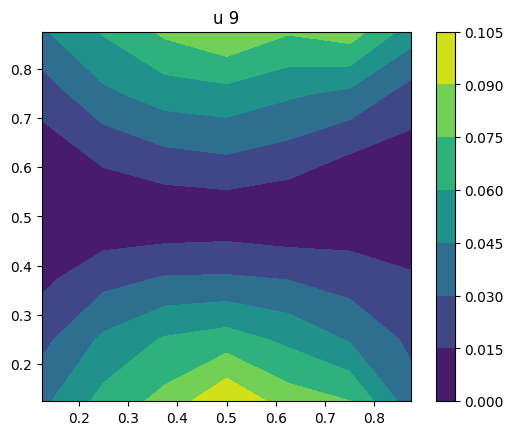

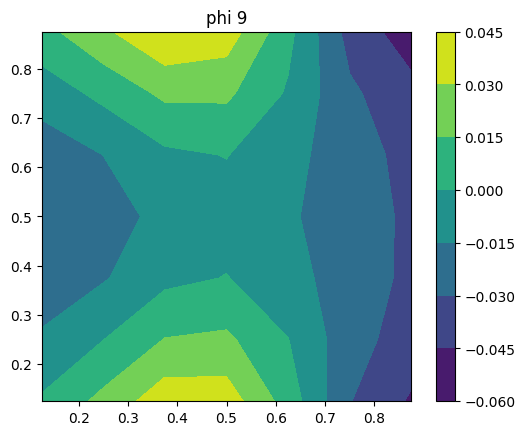

u_n vector: [[-0.041123   -0.02557995 -0.01127262 -0.00113807  0.00664507  0.02152437
   0.04291115 -0.06499833 -0.04791711 -0.02458862 -0.00291634  0.01809949
   0.04194772  0.06137383 -0.07975522 -0.06166827 -0.03105946  0.00223838
   0.02660466  0.05214195  0.07794177 -0.10368409 -0.06701552 -0.03164282
   0.0035945   0.02981042  0.05474026  0.08855241 -0.08258977 -0.0567203
  -0.02916029  0.00065455  0.02438742  0.04746142  0.07651817 -0.07517677
  -0.04369867 -0.02290744 -0.00488777  0.01451145  0.04164472  0.08305581
  -0.03594727 -0.02666404 -0.01692796 -0.00147249  0.00892686  0.02342686
   0.05236178]
 [-0.03642835 -0.06396192 -0.08970139 -0.0974445  -0.10018674 -0.07158689
  -0.04912039 -0.02665958 -0.0453395  -0.06275748 -0.06512819 -0.05937691
  -0.04516412 -0.02874844 -0.01160412 -0.02605285 -0.03071716 -0.03310887
  -0.02420603 -0.02139388 -0.01139625  0.00219305  0.00272506  0.007145
   0.00462838  0.00556078  0.00240603  0.00087288  0.01126258  0.02421773
   0.03458426 

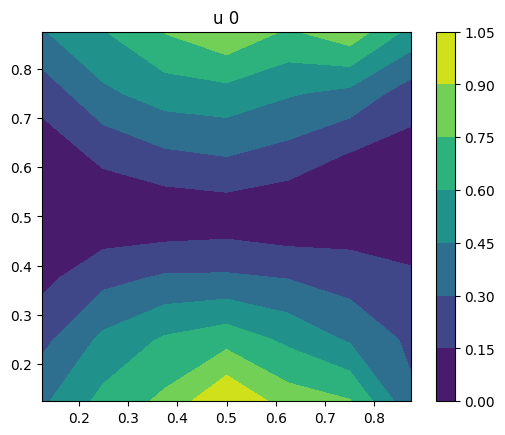

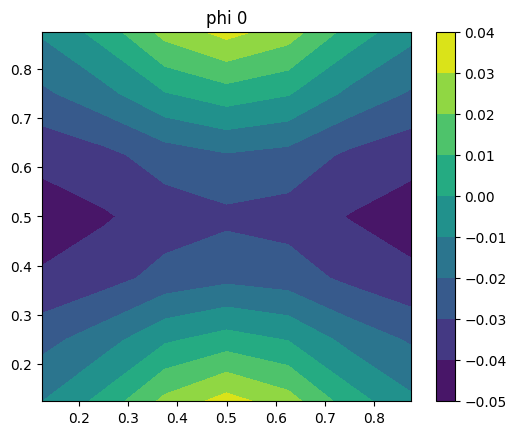

i 1
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


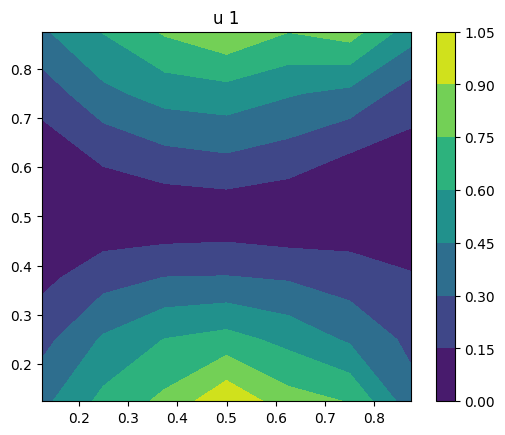

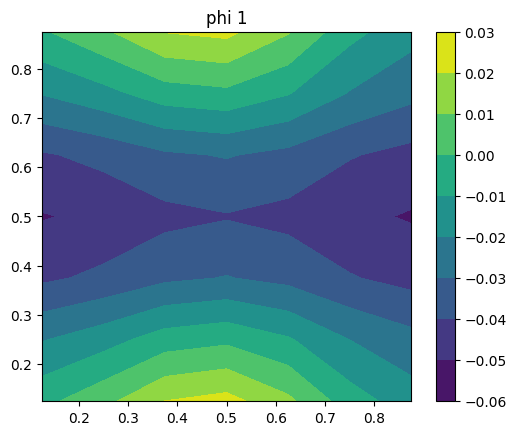

i 2
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


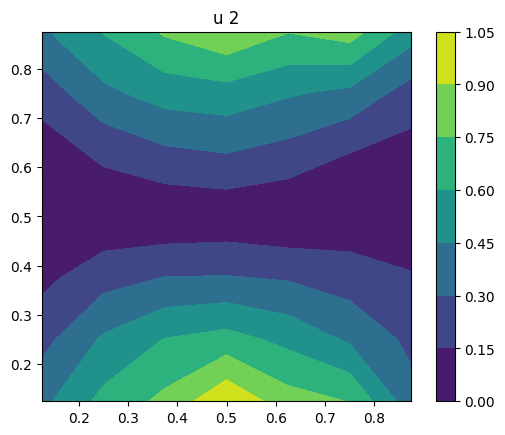

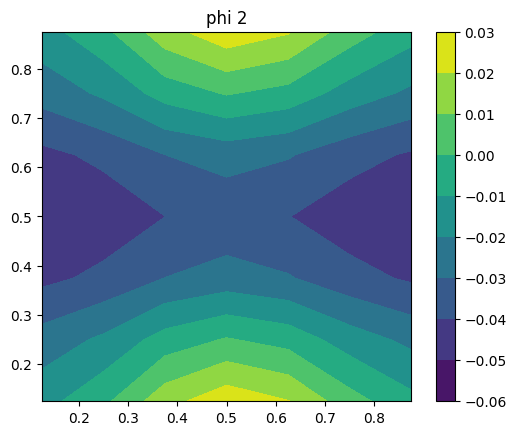

i 3
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


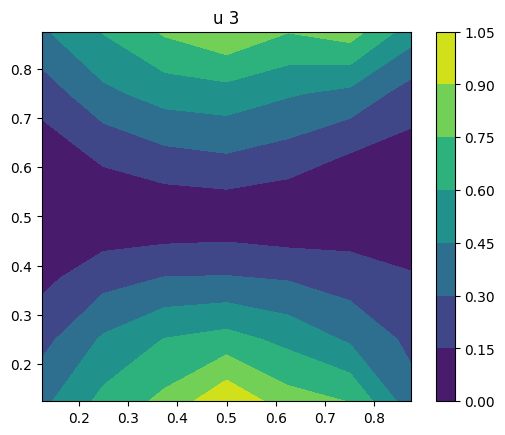

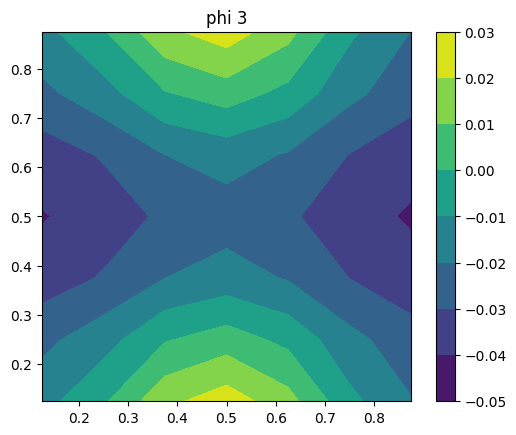

i 4
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


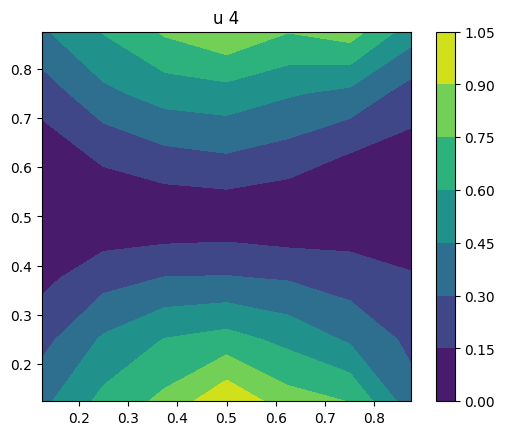

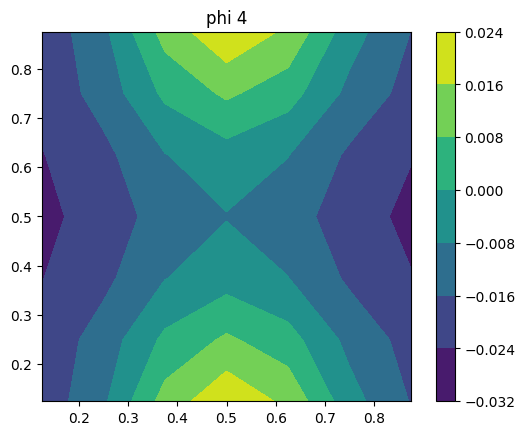

i 5
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


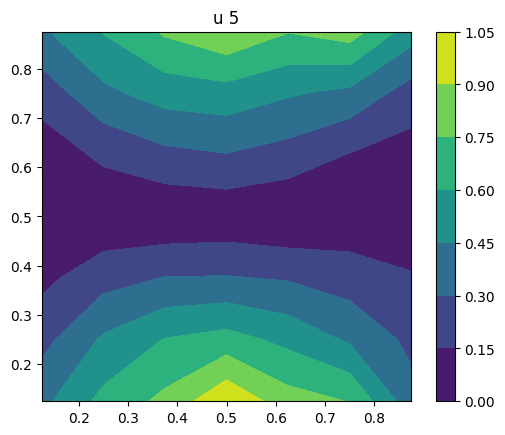

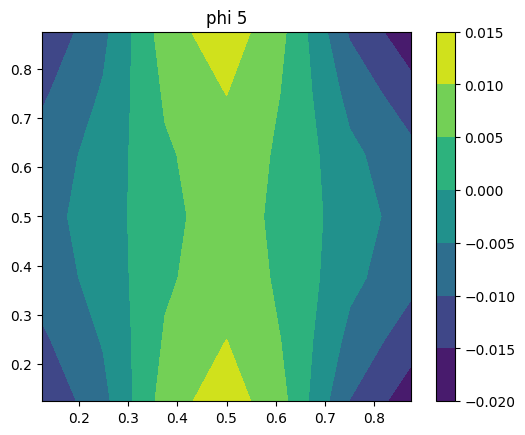

i 6
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


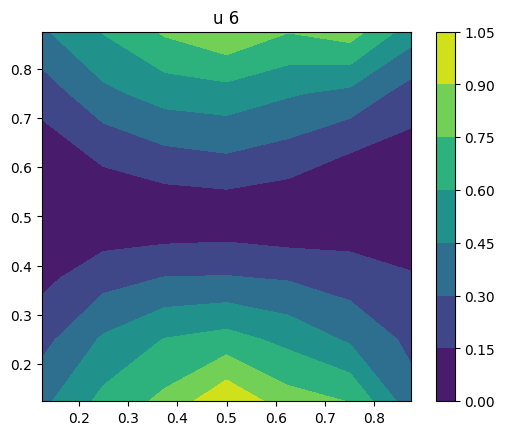

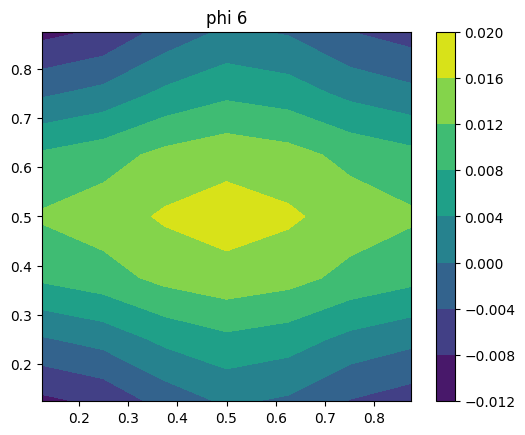

i 7
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


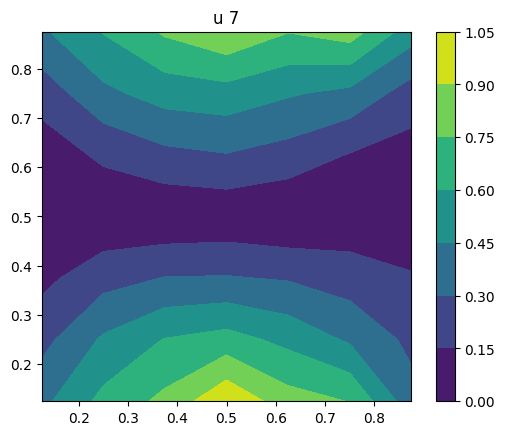

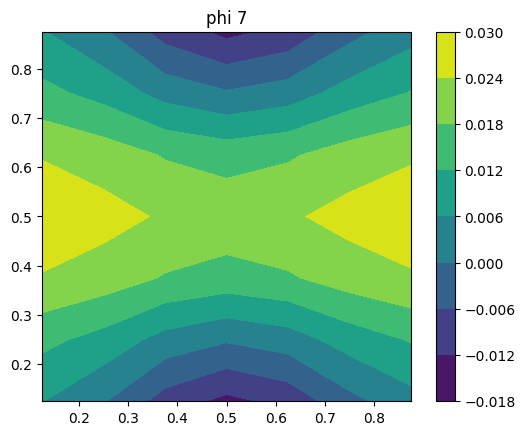

i 8
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


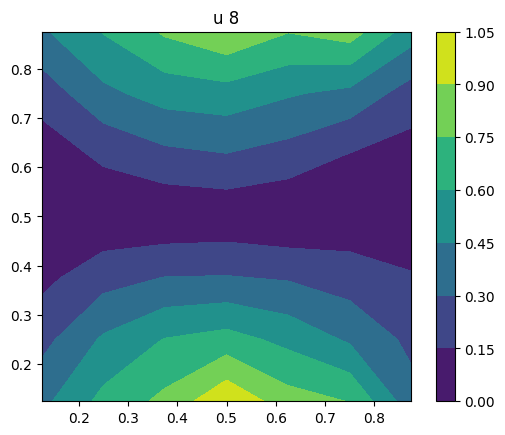

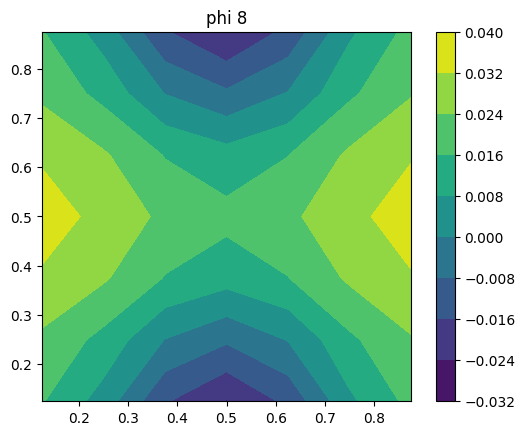

i 9
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


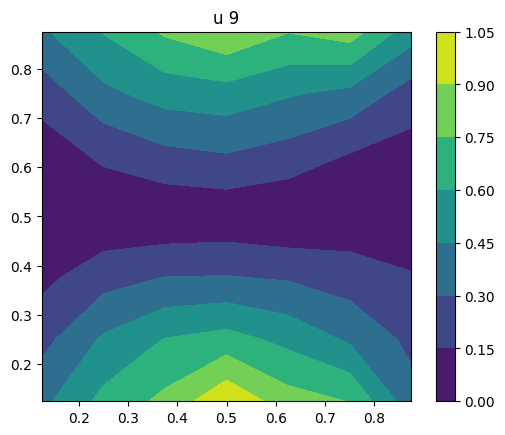

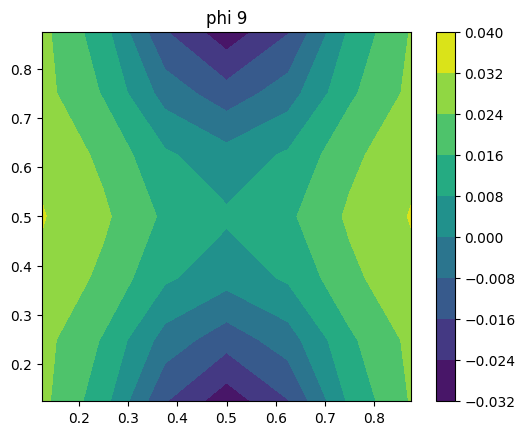

i 10
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


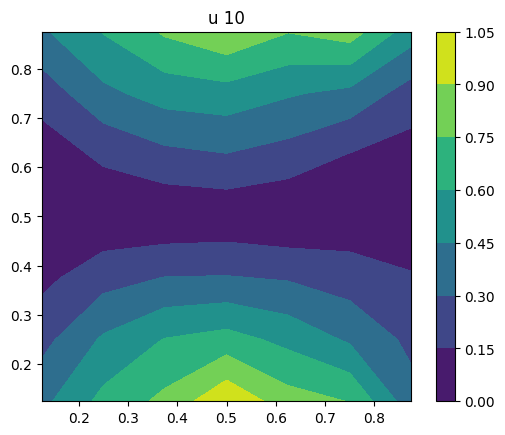

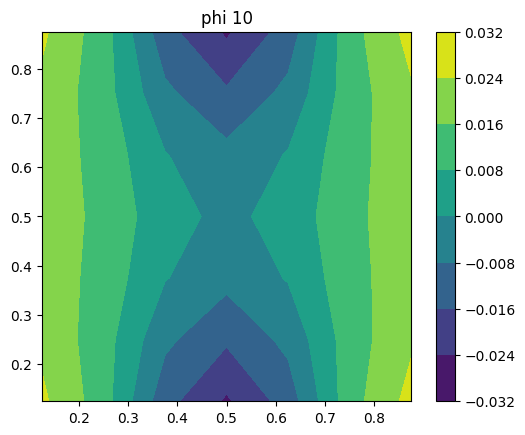

i 11
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


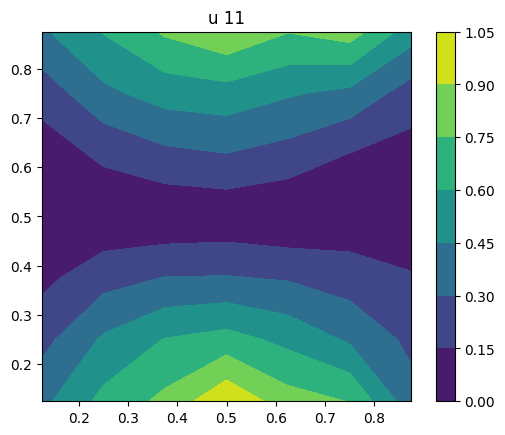

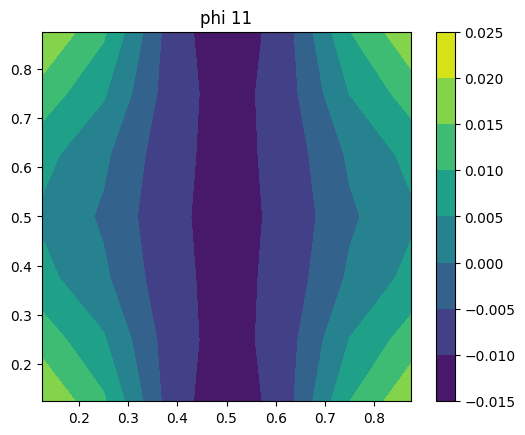

i 12
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


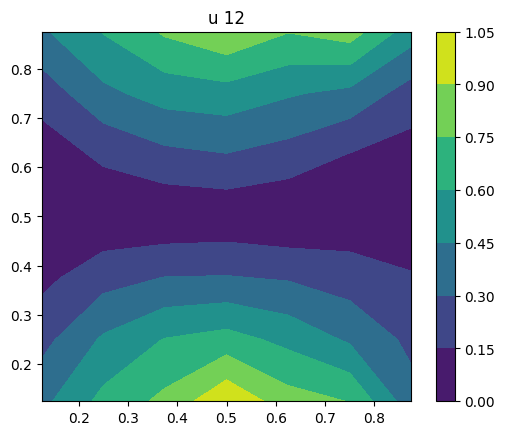

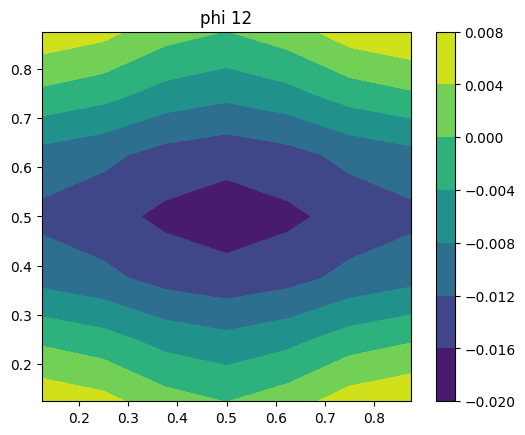

i 13
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


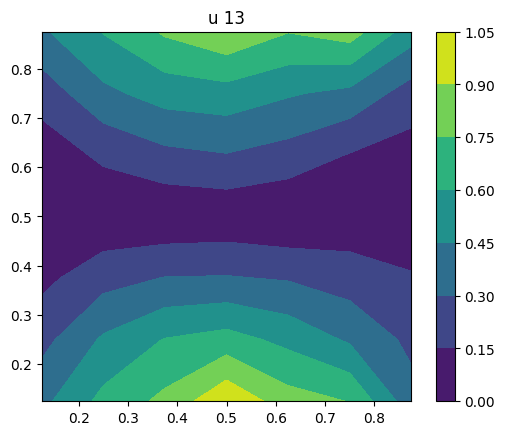

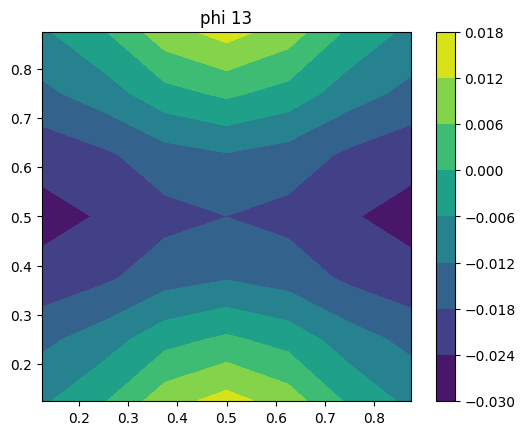

i 14
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


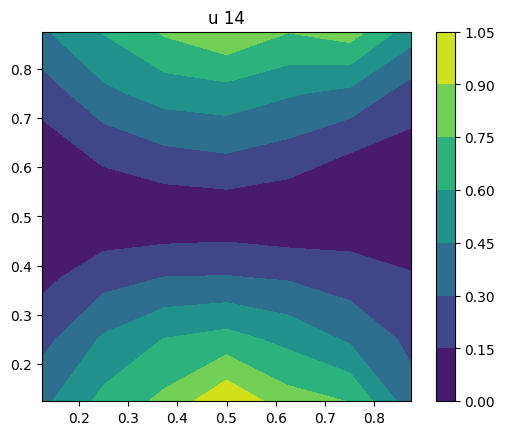

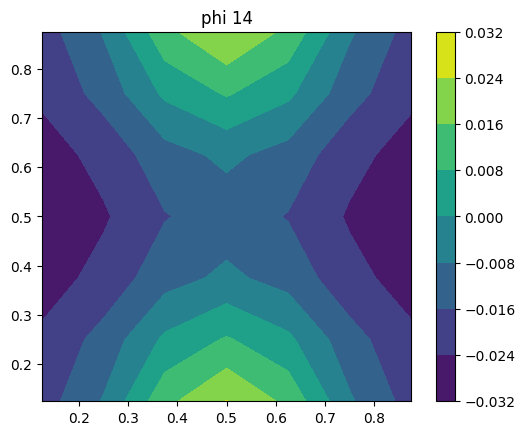

i 15
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


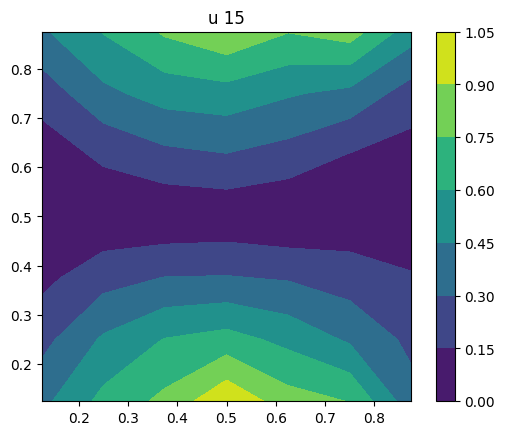

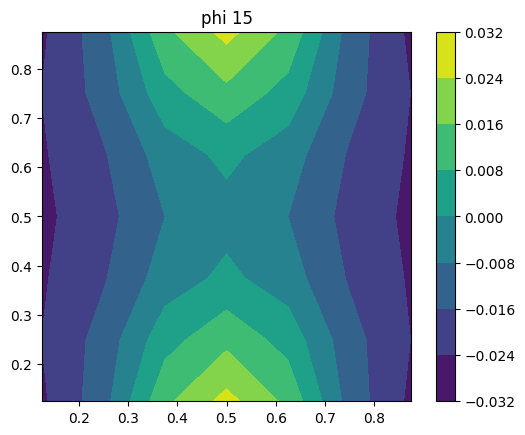

i 16
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


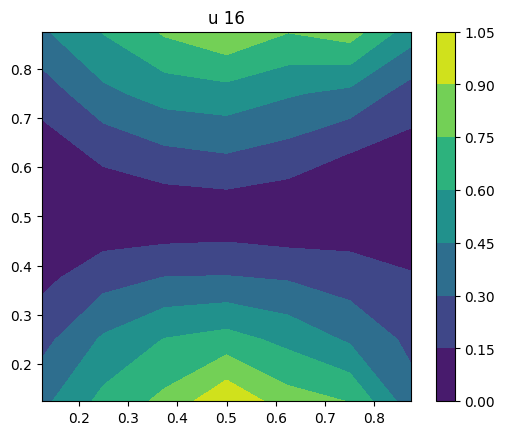

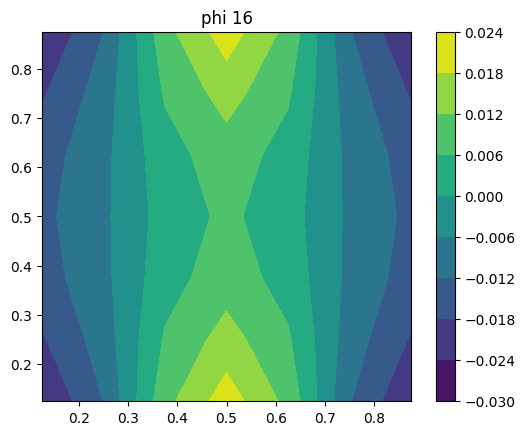

i 17
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


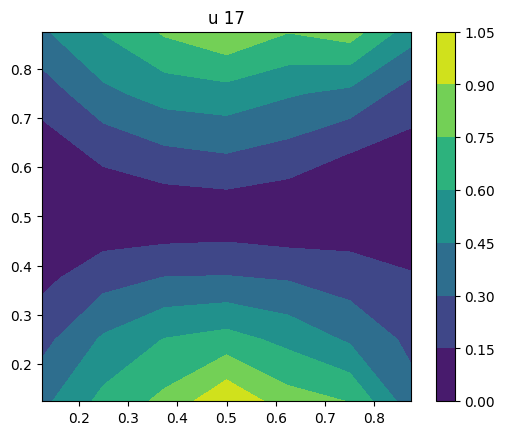

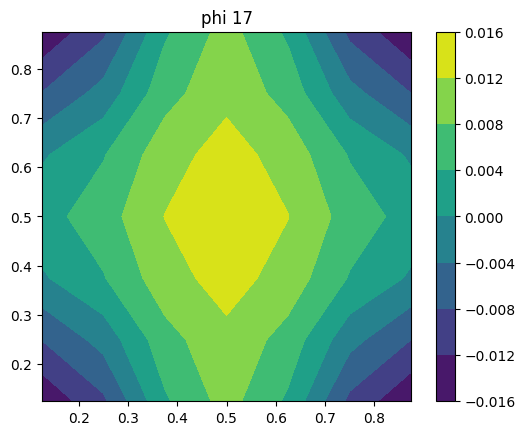

i 18
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


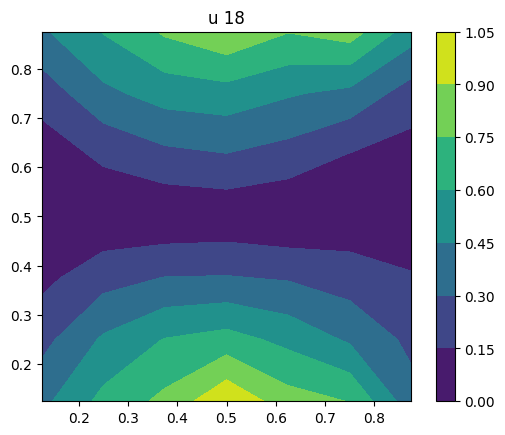

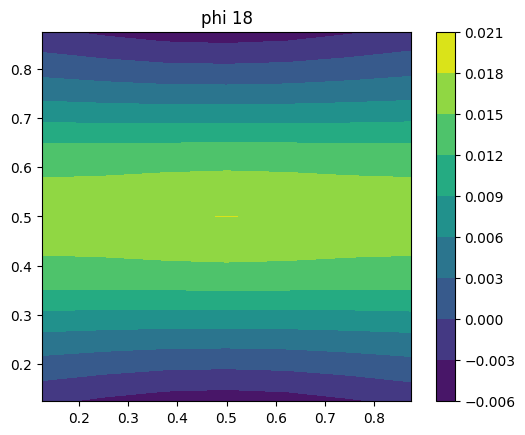

i 19
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


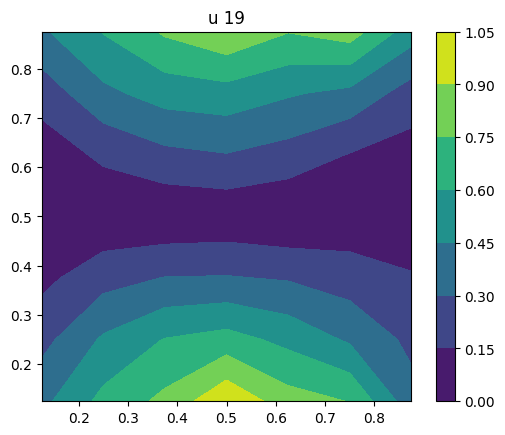

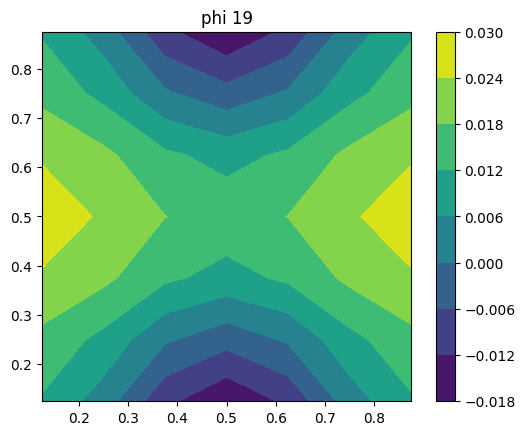

i 20
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


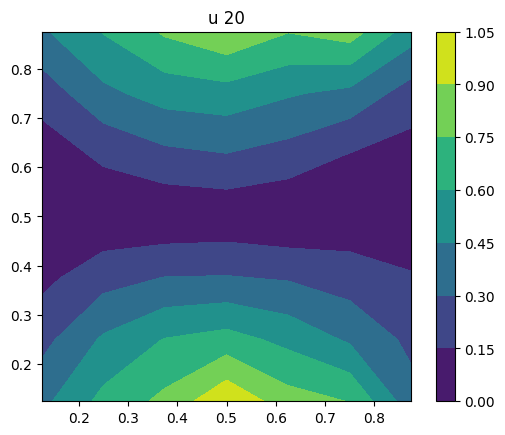

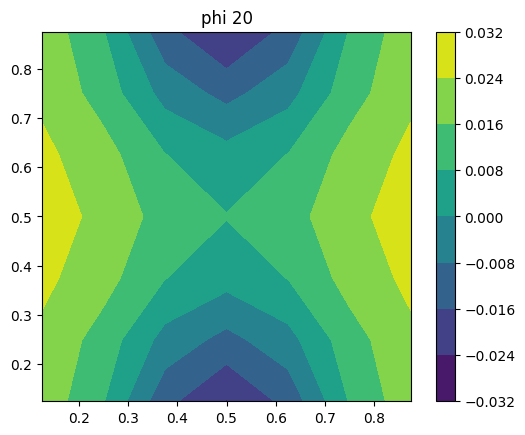

i 21
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


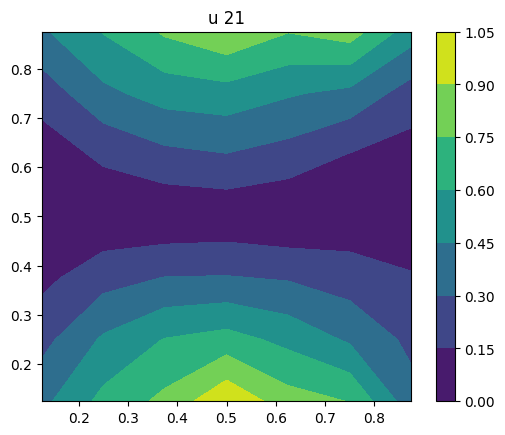

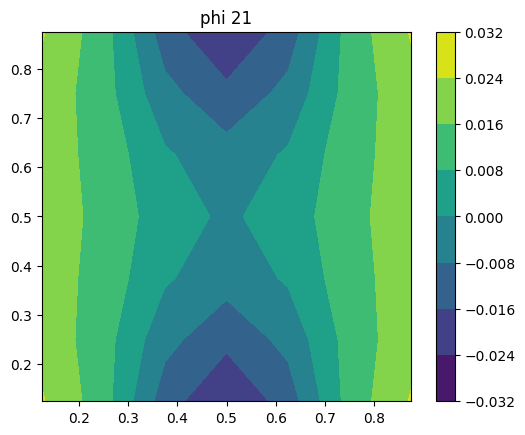

i 22
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


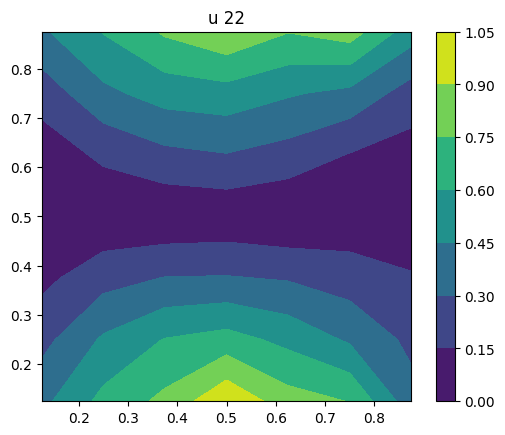

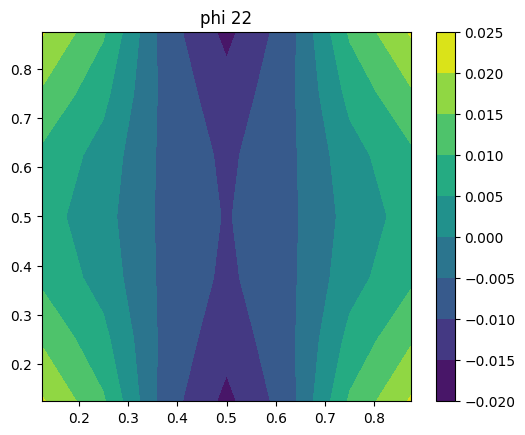

i 23
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


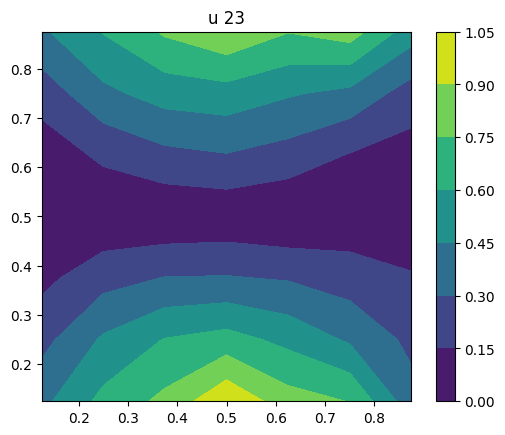

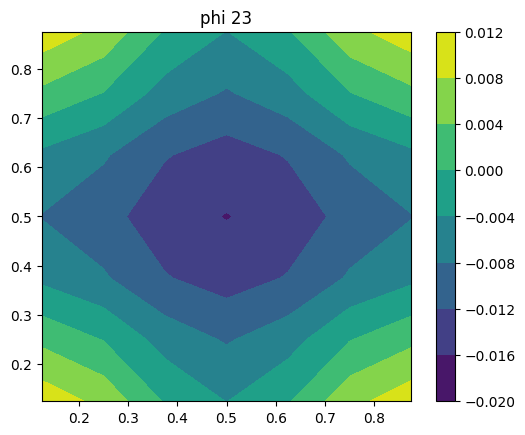

i 24
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


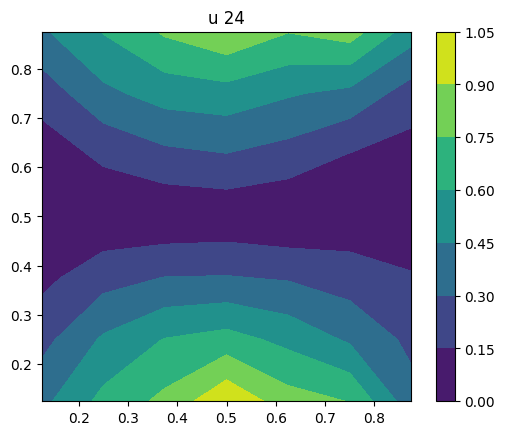

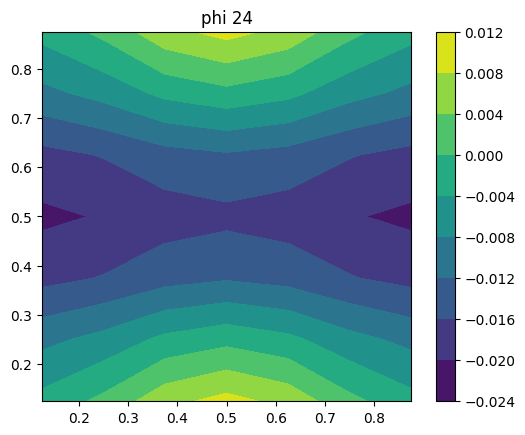

i 25
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


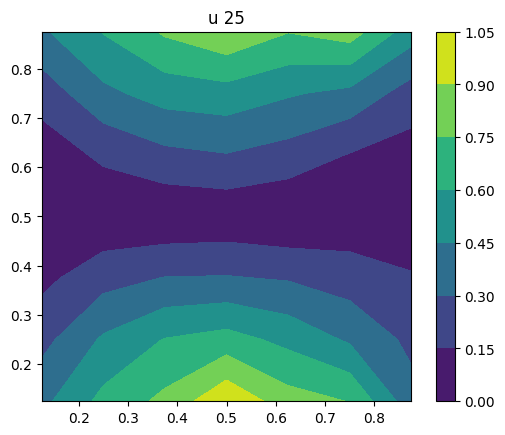

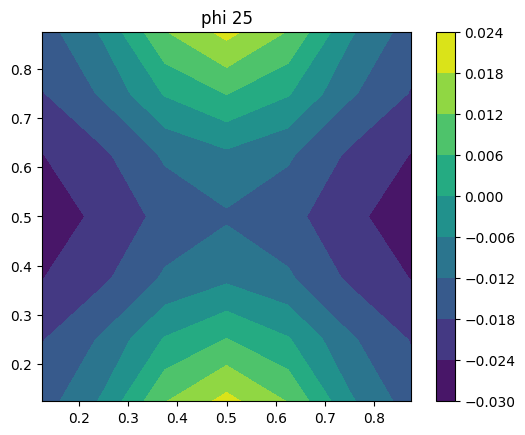

i 26
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


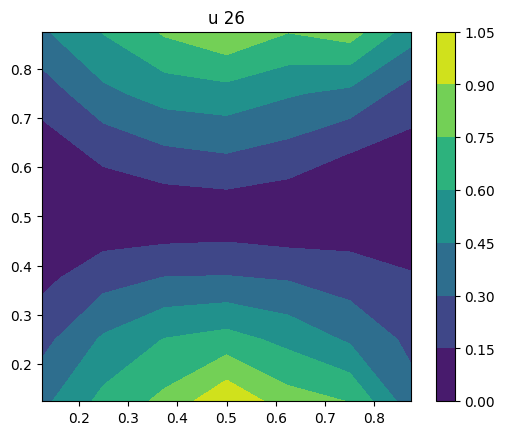

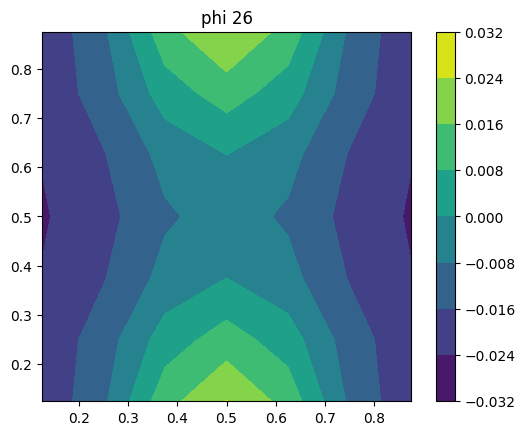

i 27
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


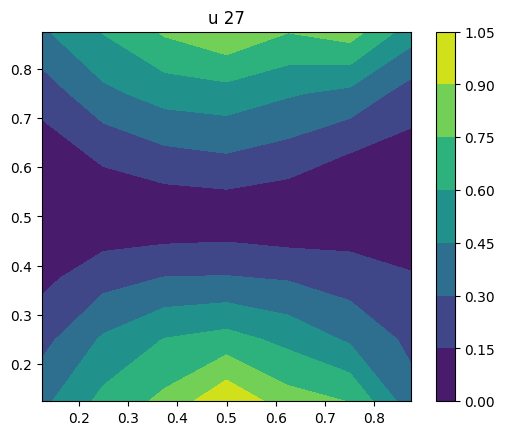

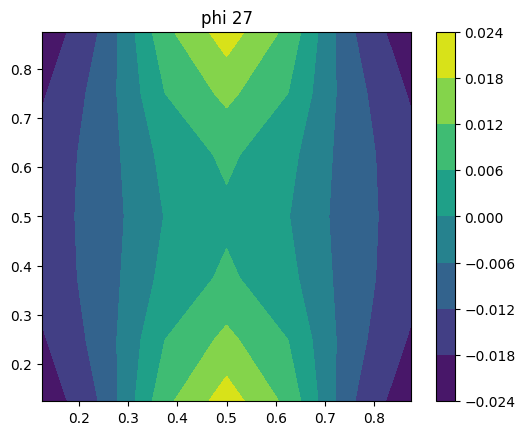

i 28
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


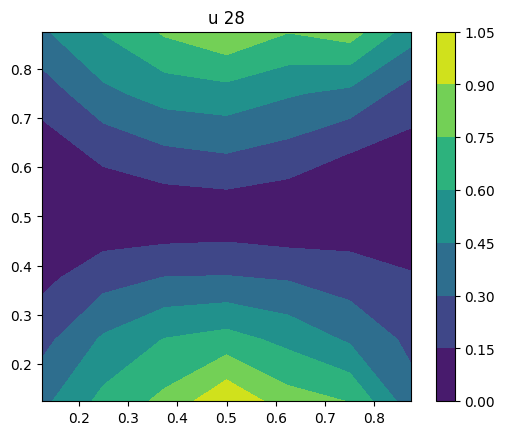

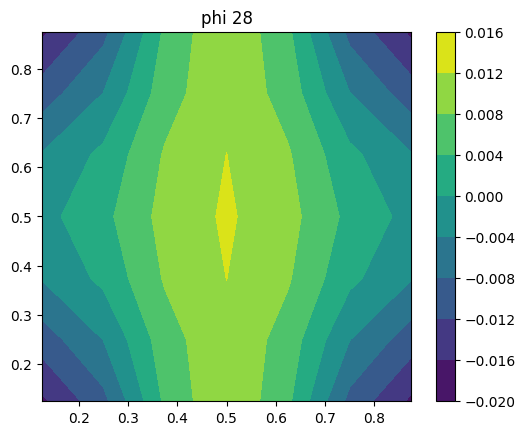

i 29
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


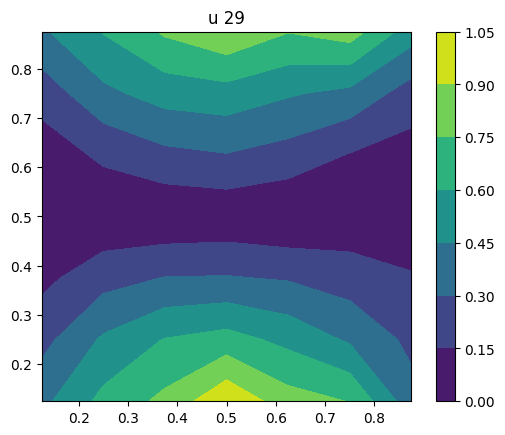

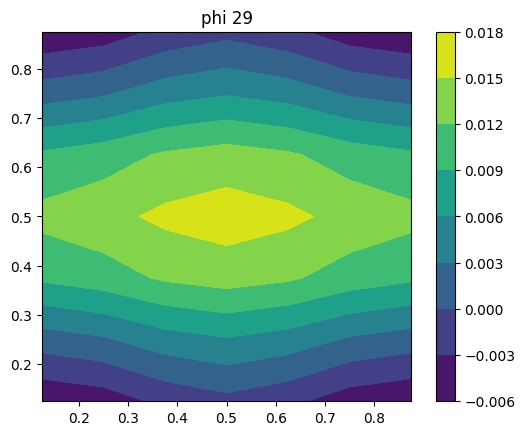

i 30
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


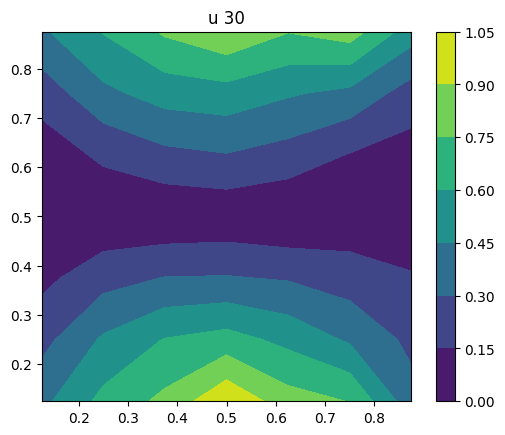

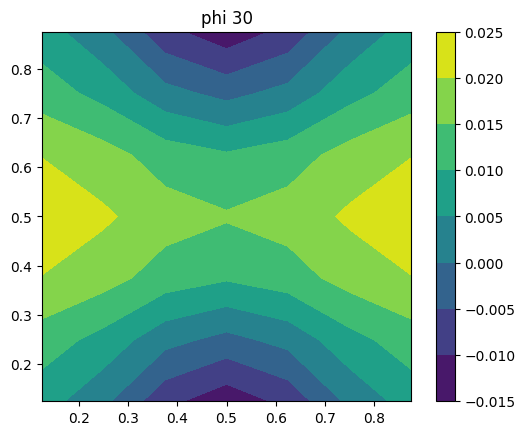

i 31
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


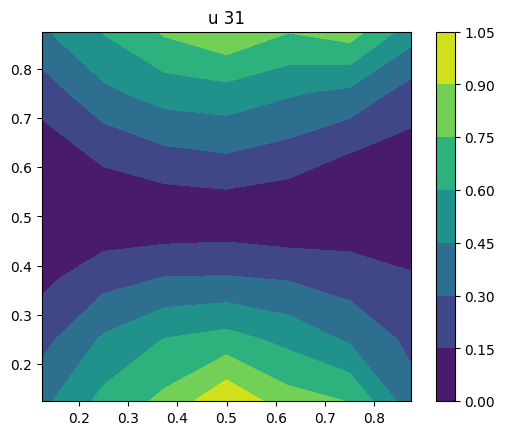

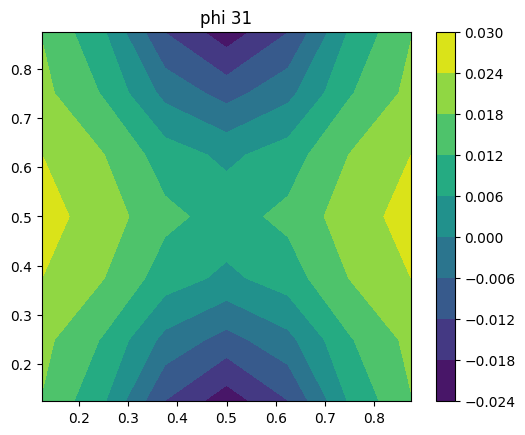

i 32
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


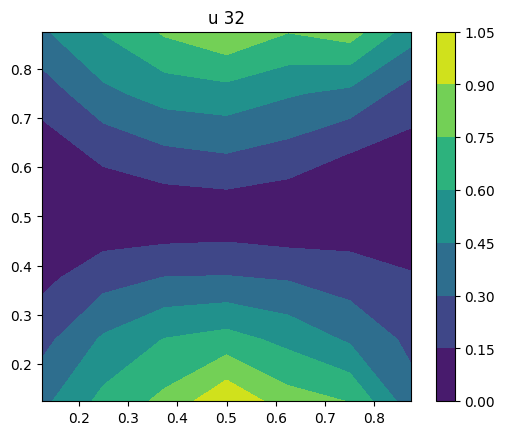

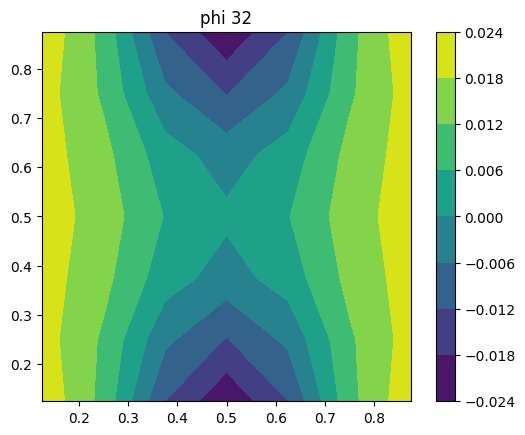

i 33
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


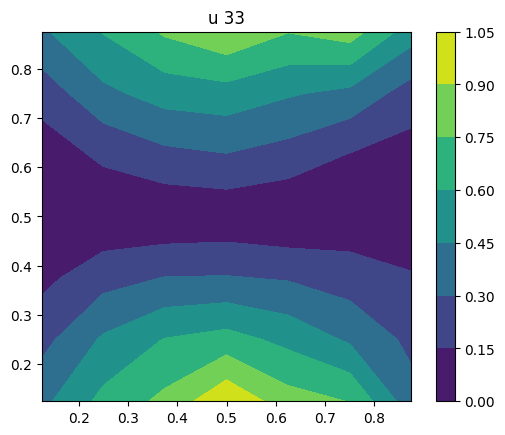

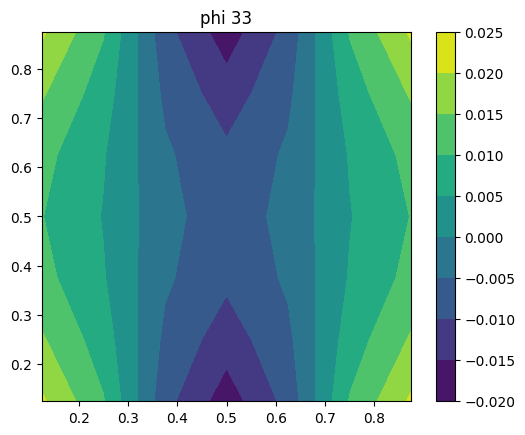

i 34
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


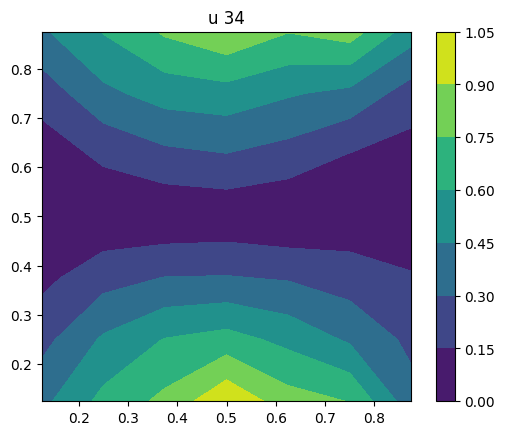

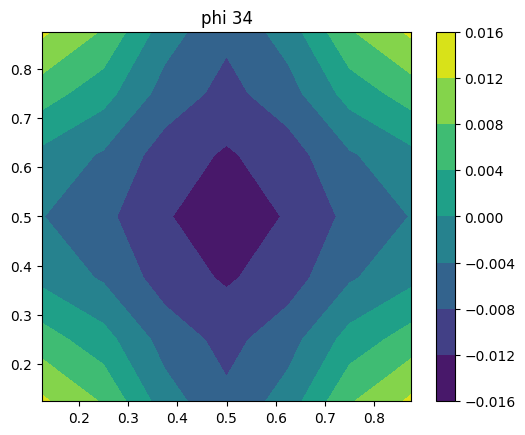

i 35
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


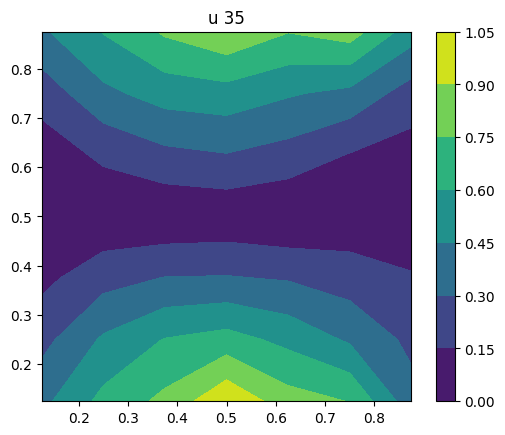

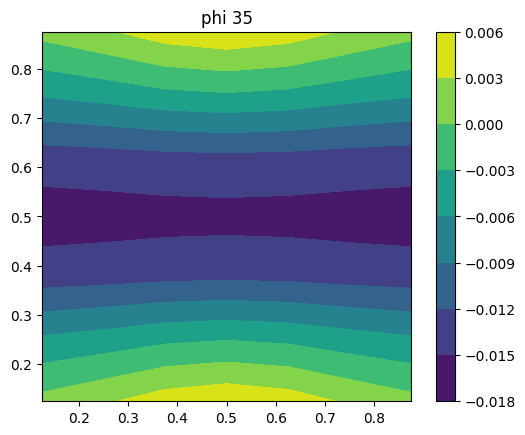

i 36
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


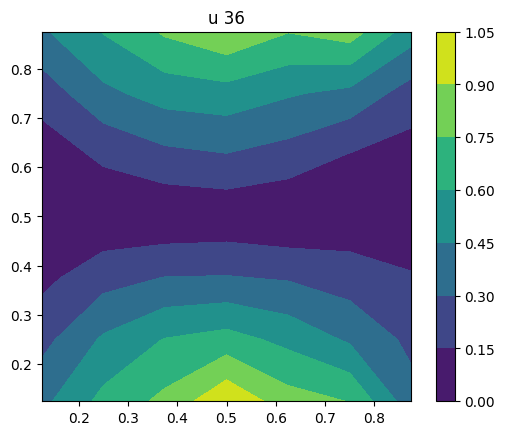

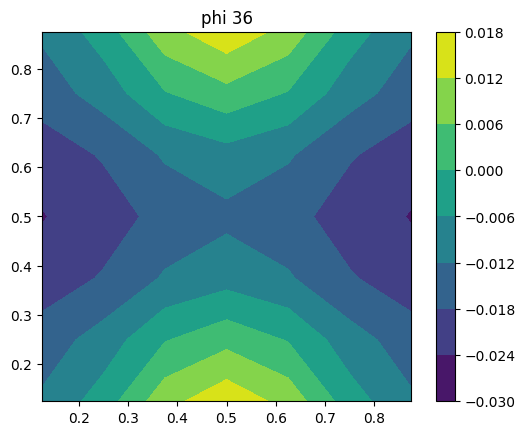

i 37
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


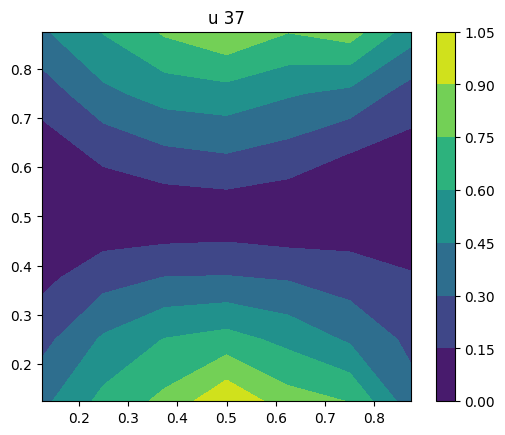

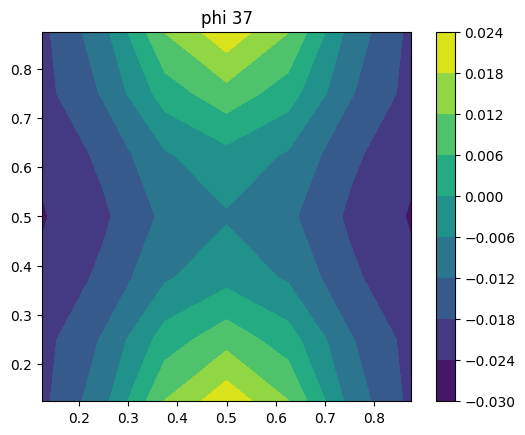

i 38
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


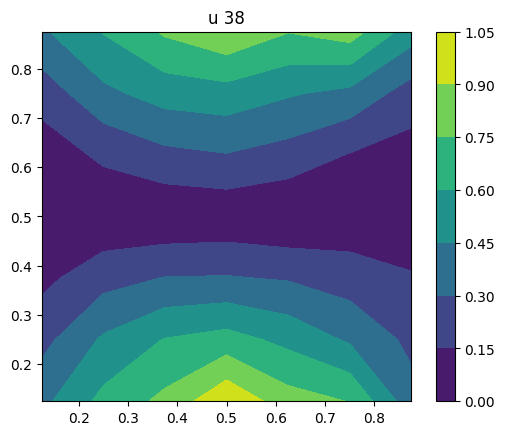

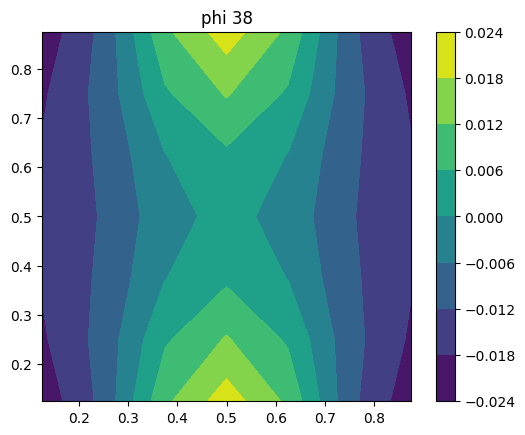

i 39
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


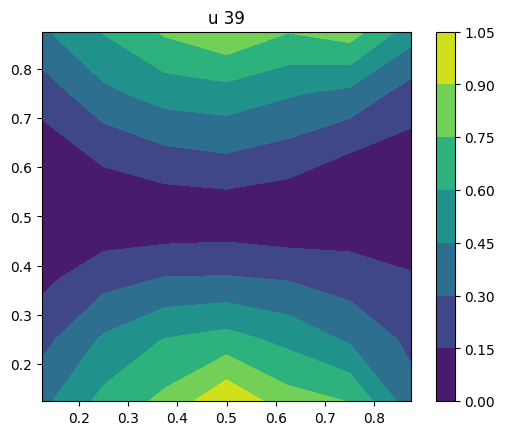

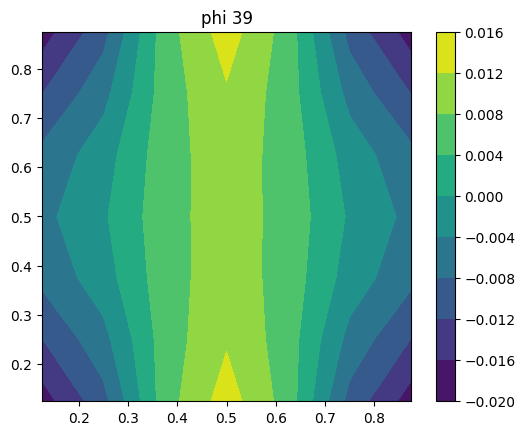

i 40
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


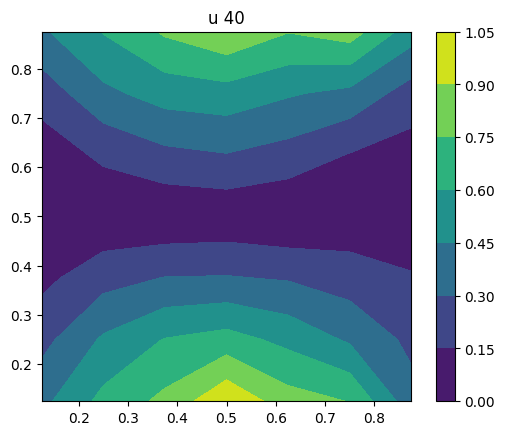

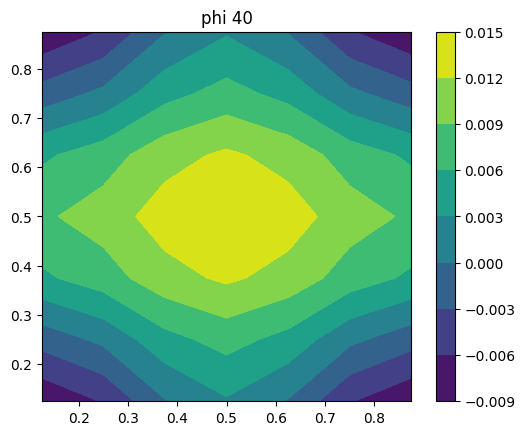

i 41
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


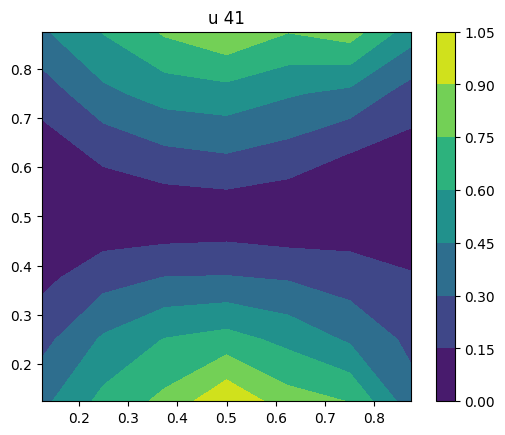

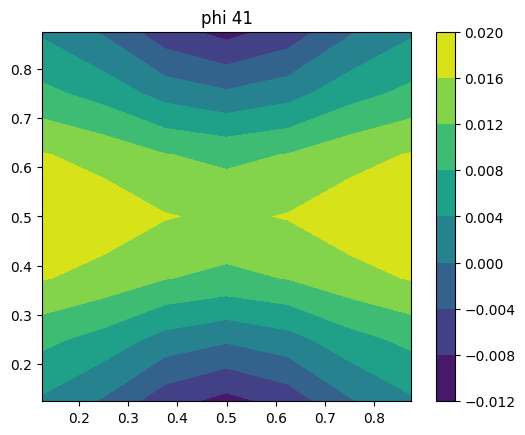

i 42
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


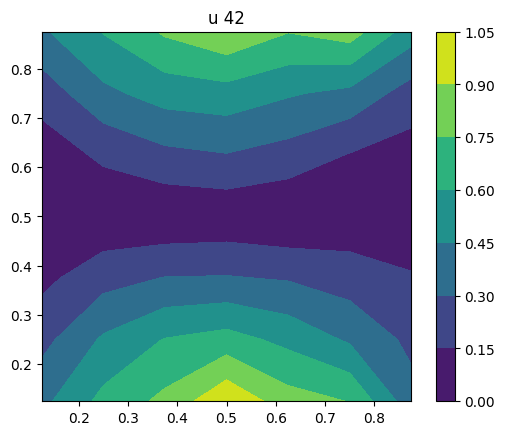

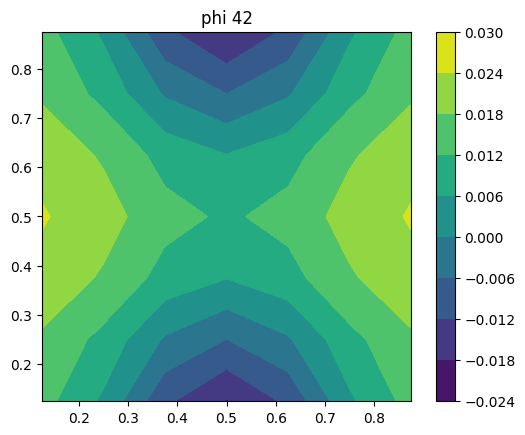

i 43
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


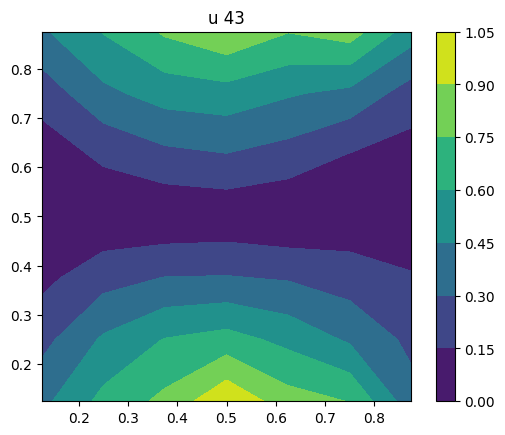

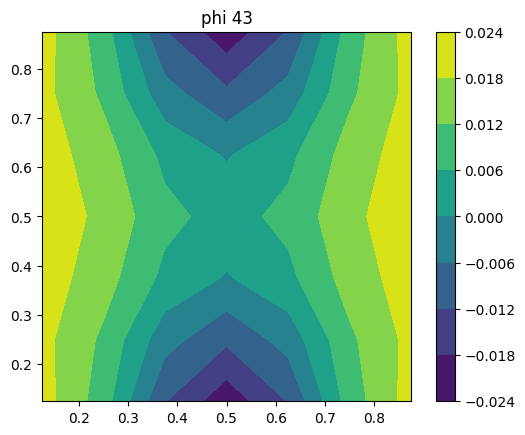

i 44
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


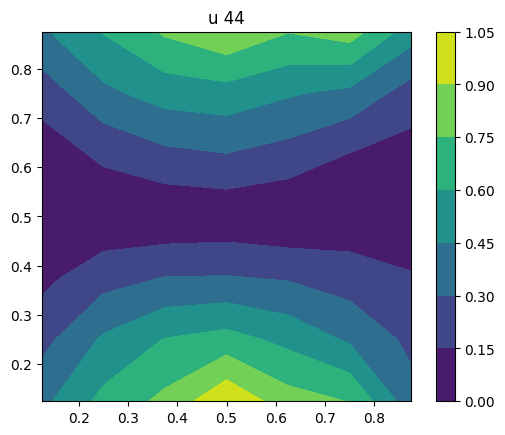

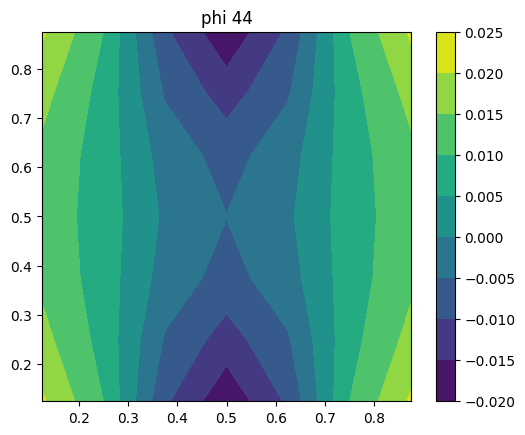

i 45
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


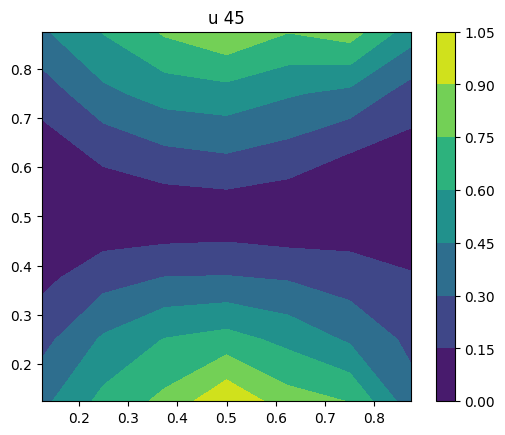

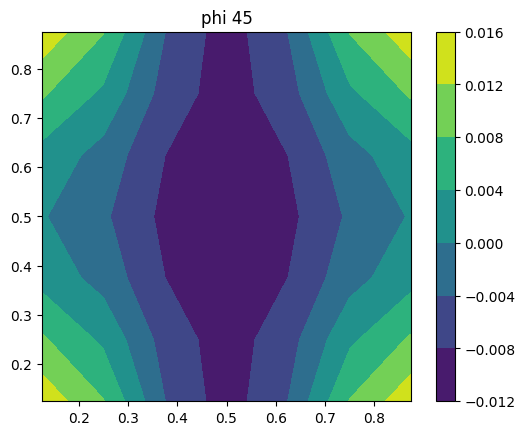

i 46
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


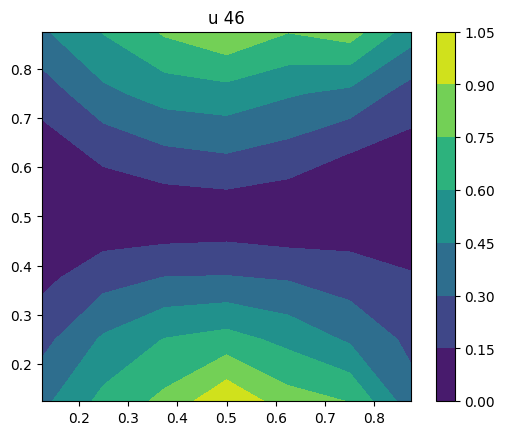

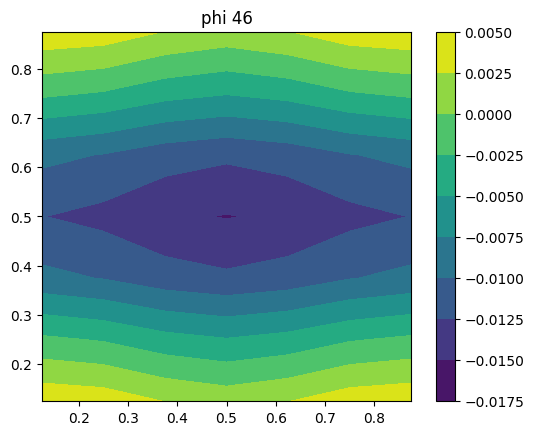

i 47
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


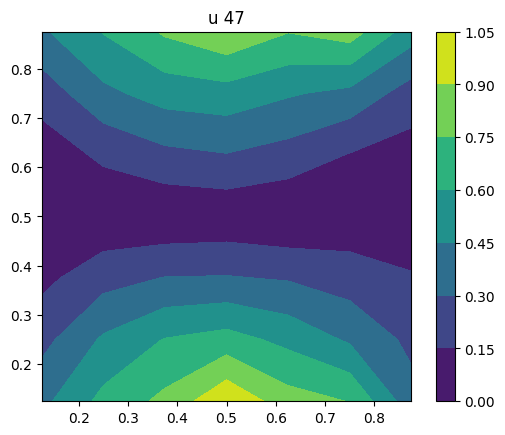

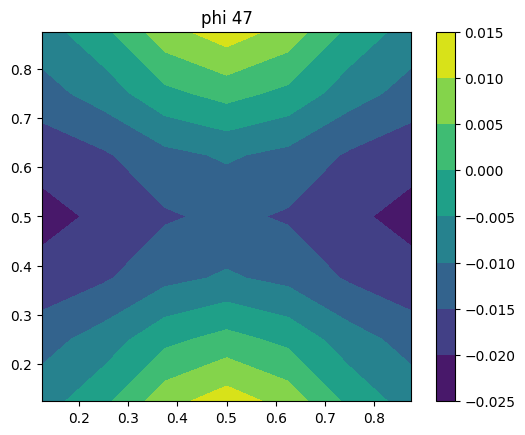

i 48
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


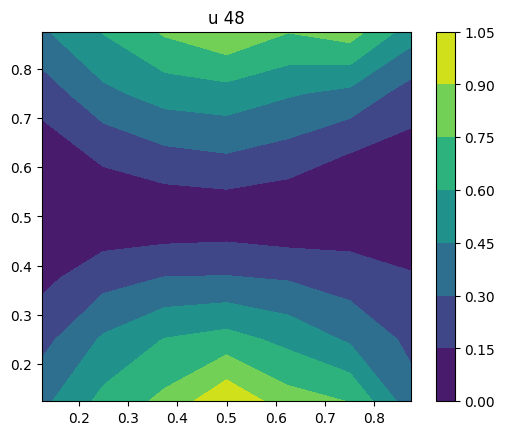

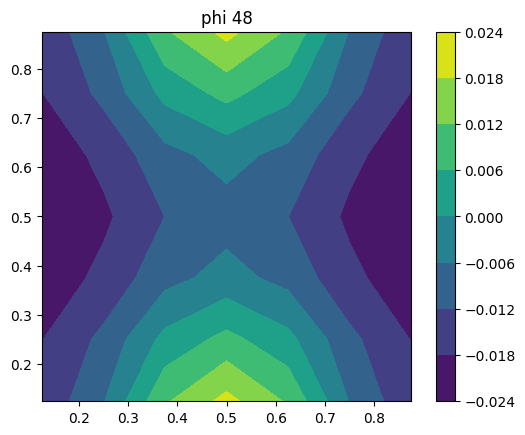

i 49
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


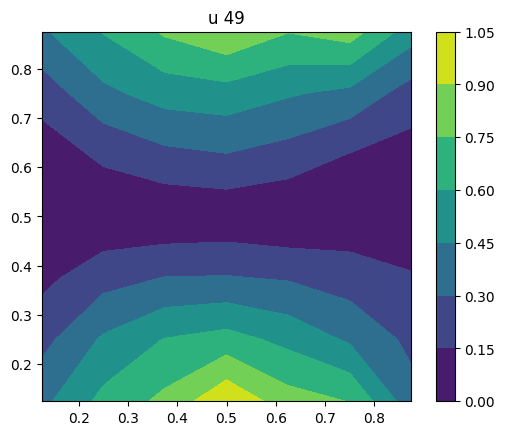

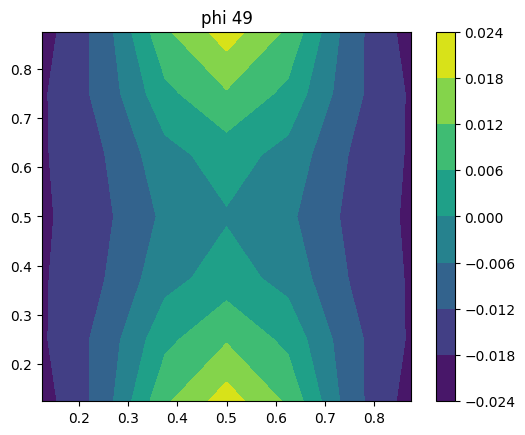

i 50
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


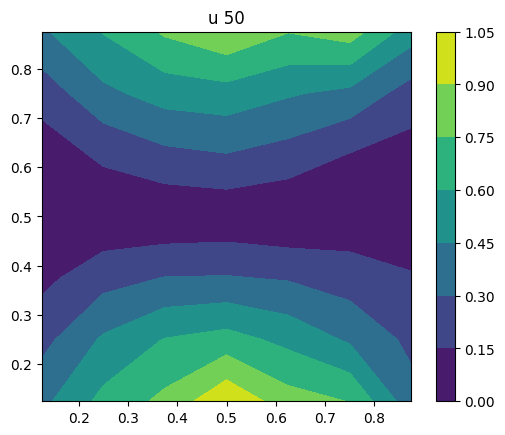

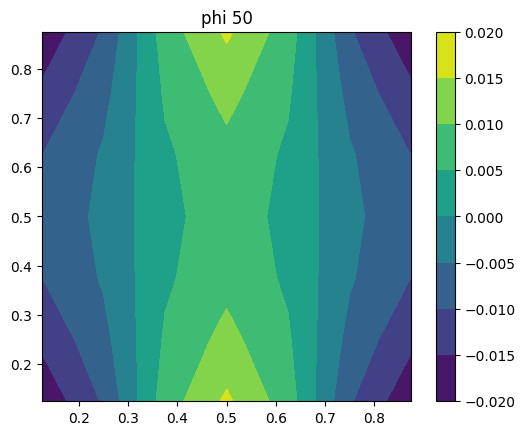

i 51
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


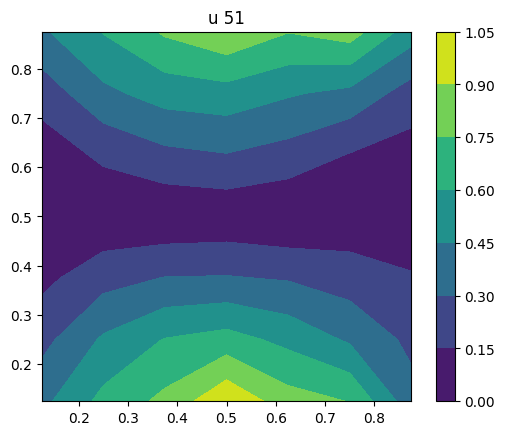

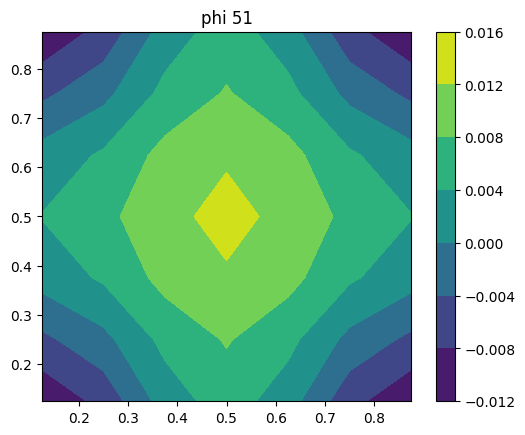

i 52
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


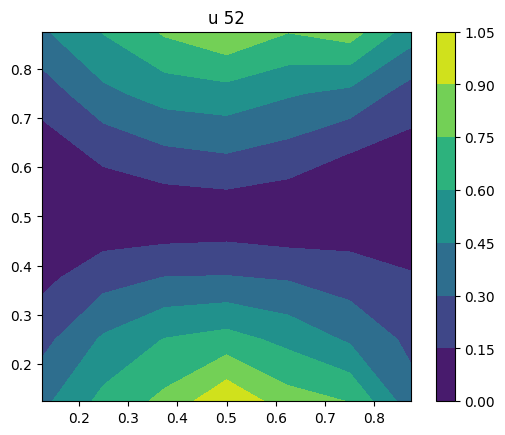

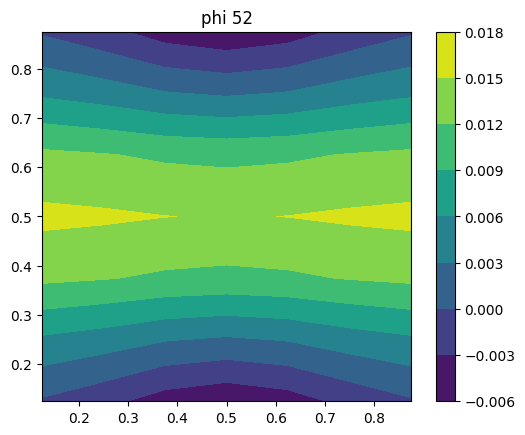

i 53
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


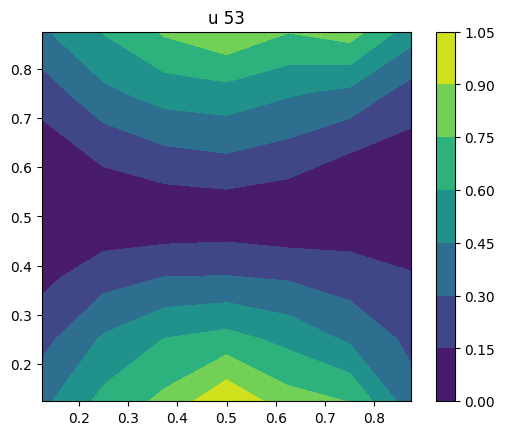

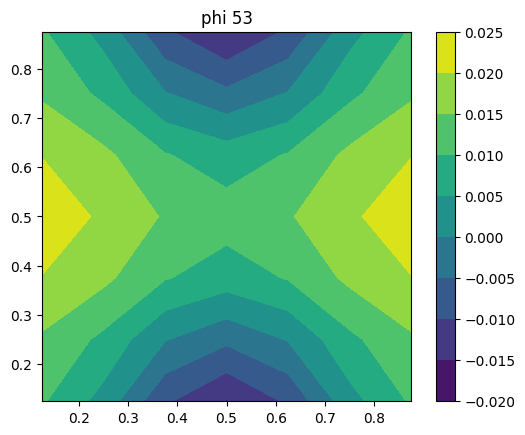

i 54
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


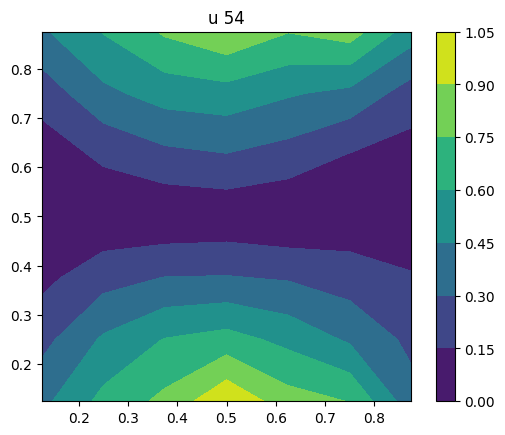

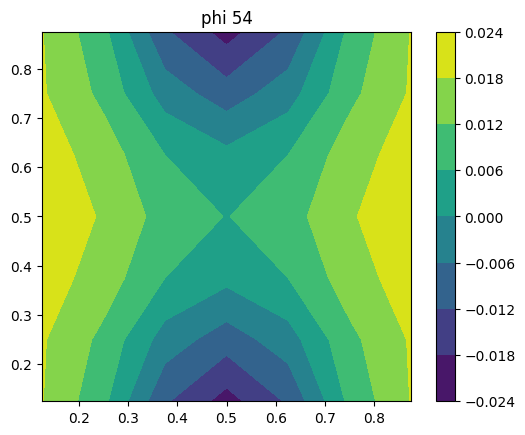

i 55
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


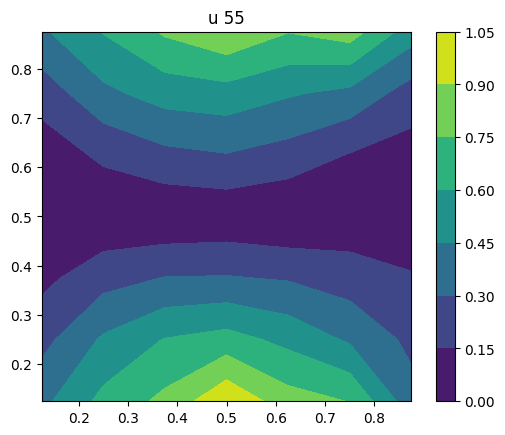

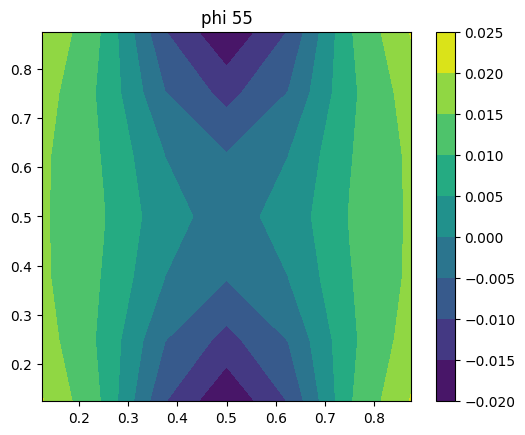

i 56
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


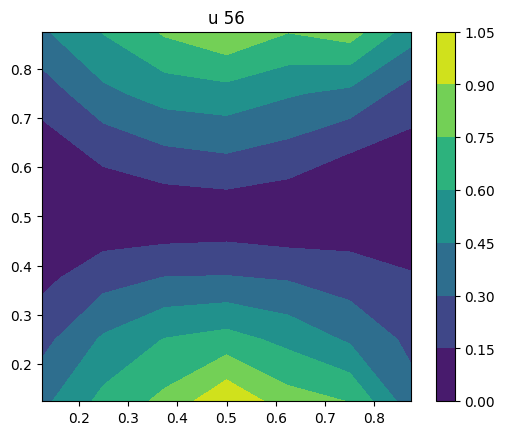

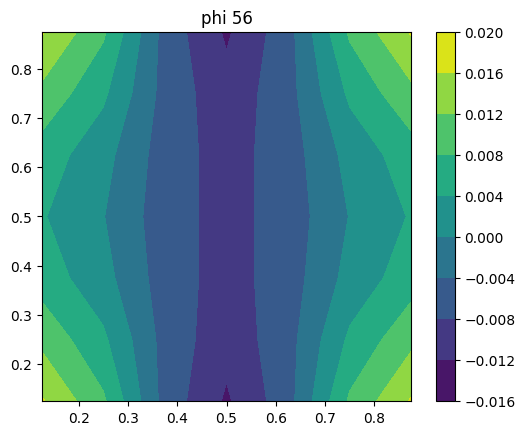

i 57
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


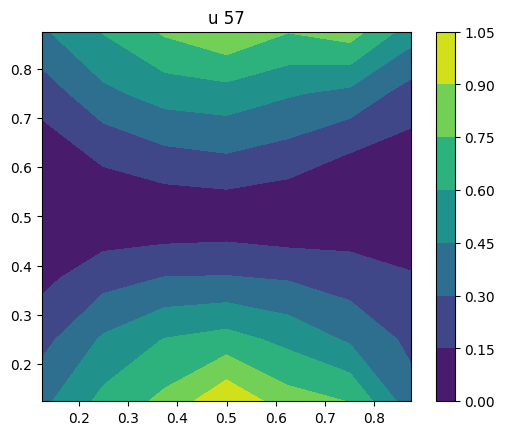

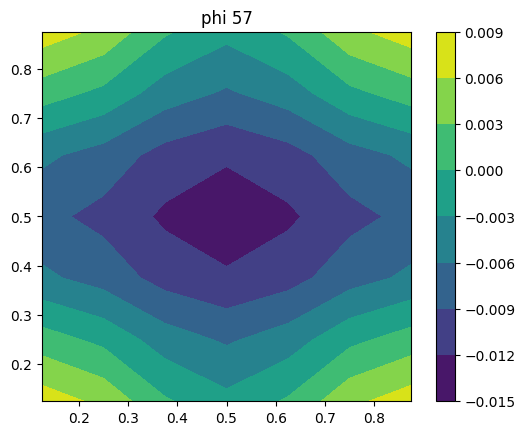

i 58
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


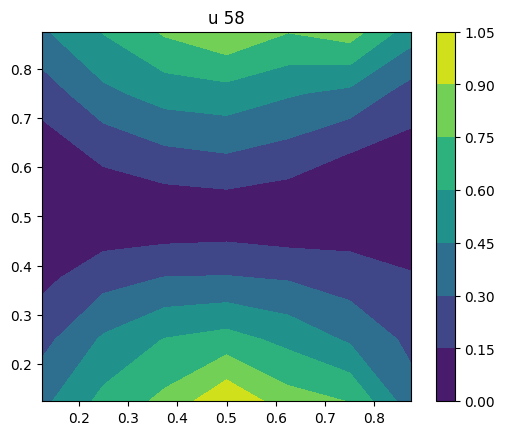

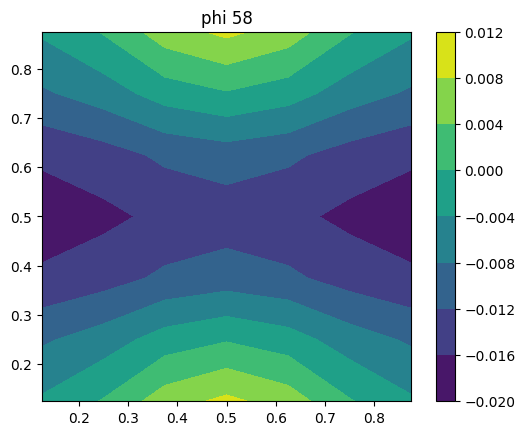

i 59
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


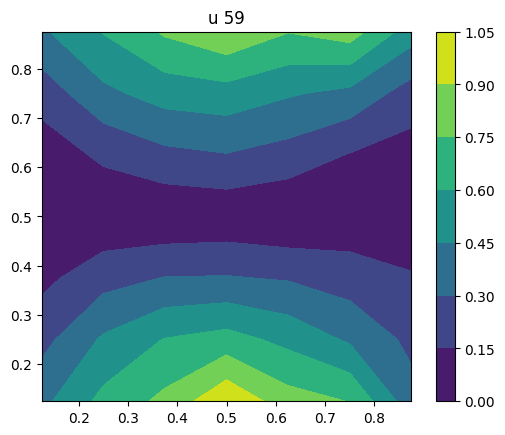

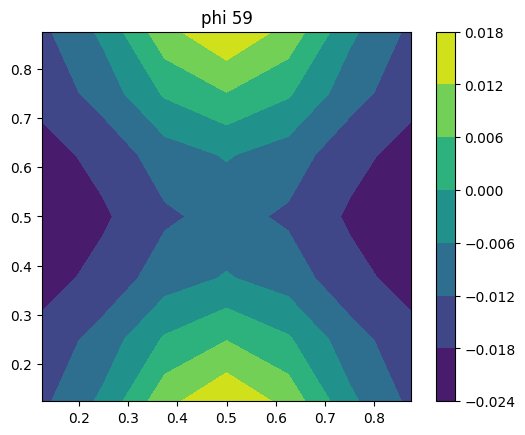

i 60
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


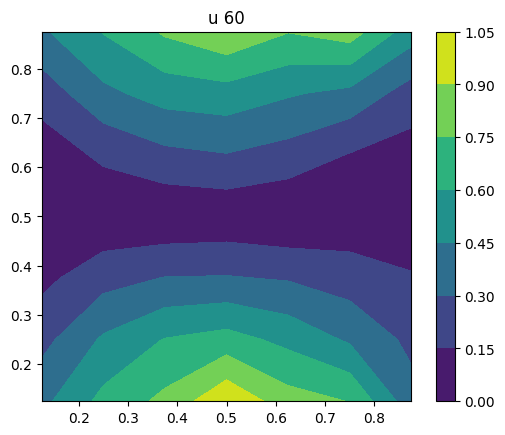

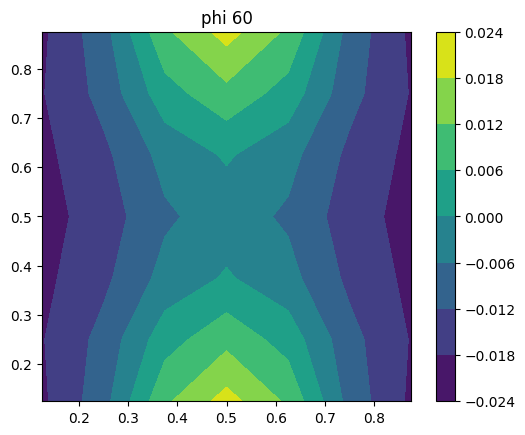

i 61
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


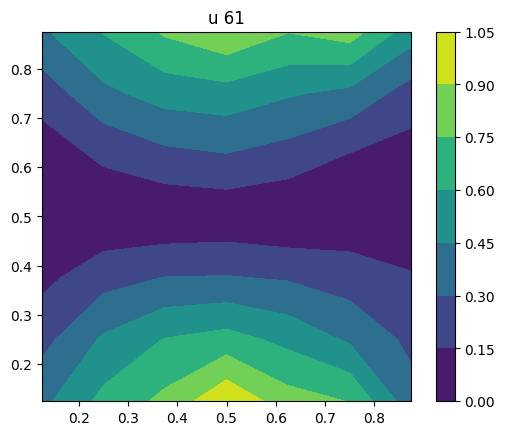

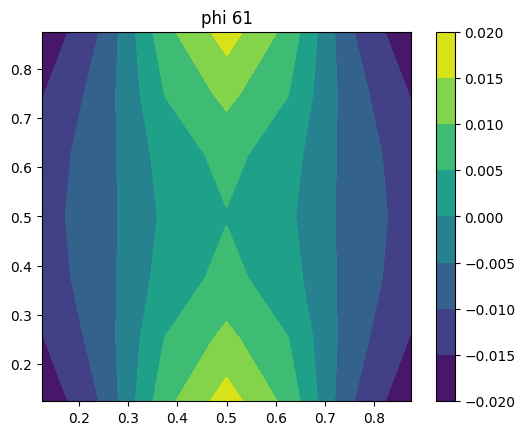

i 62
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


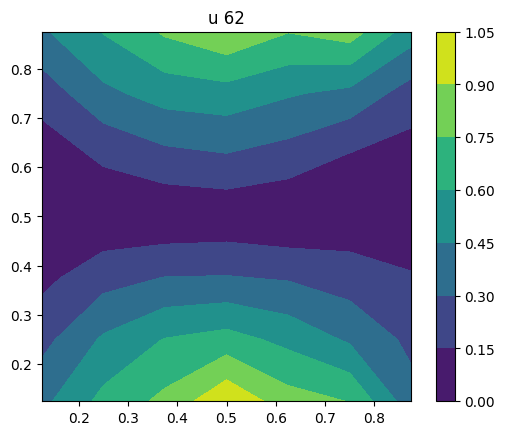

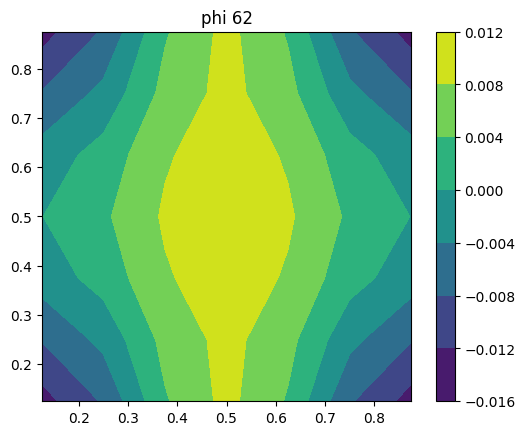

i 63
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


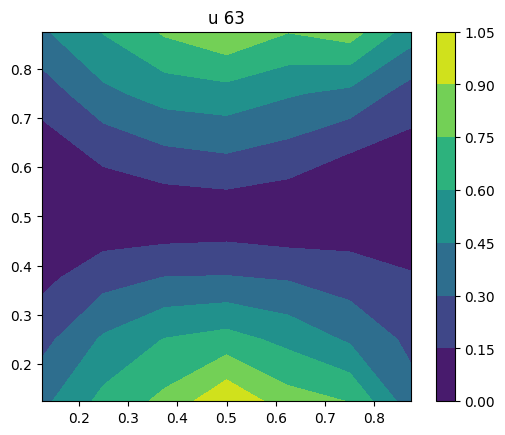

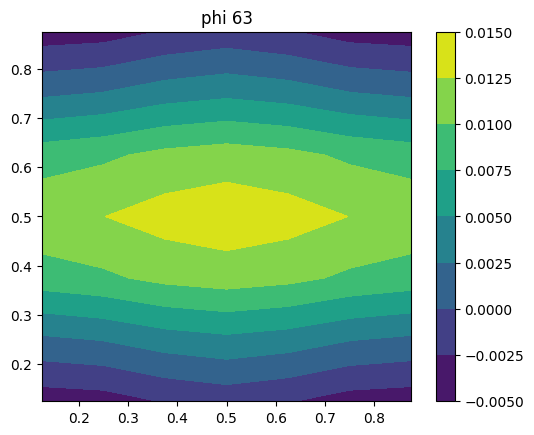

i 64
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


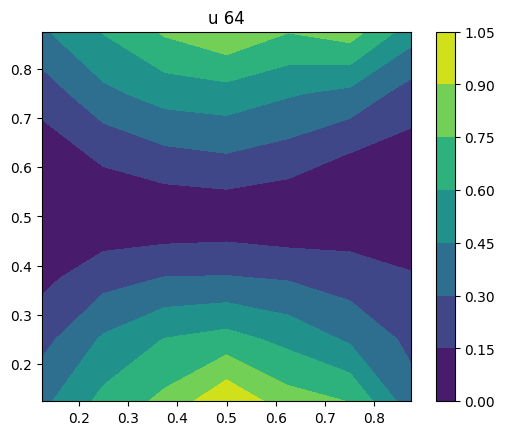

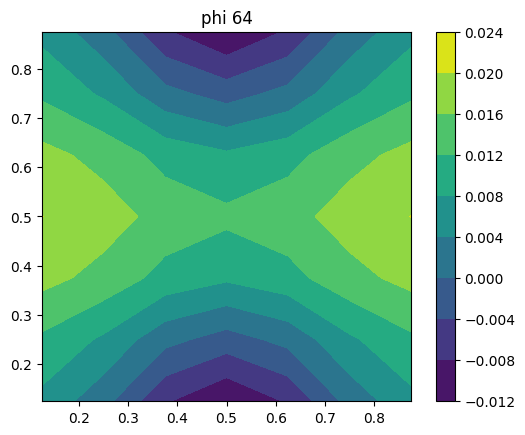

i 65
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


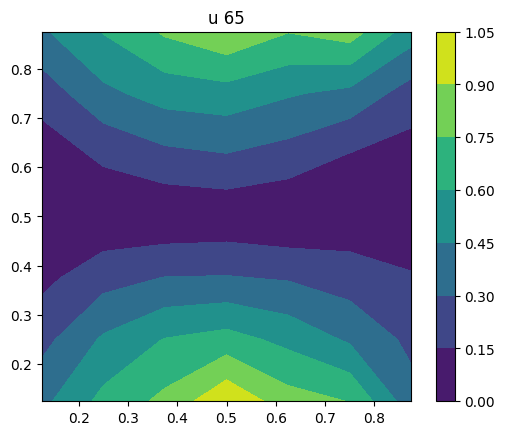

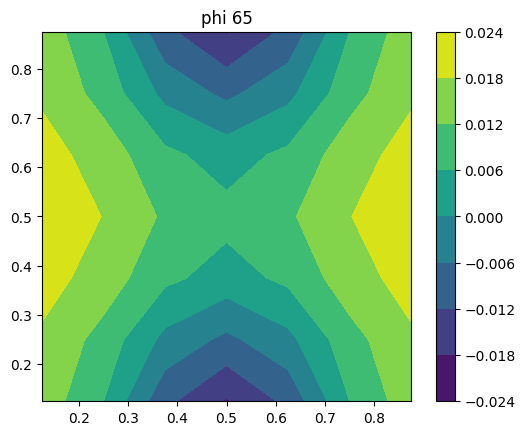

i 66
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


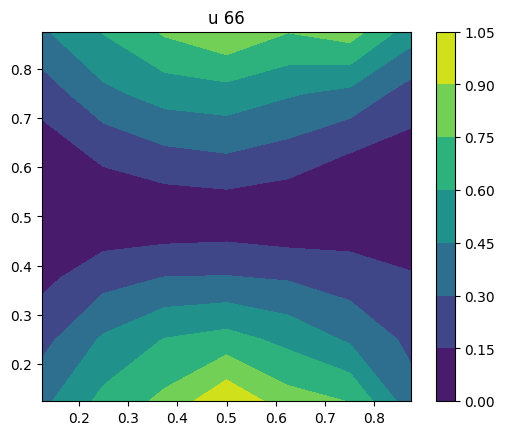

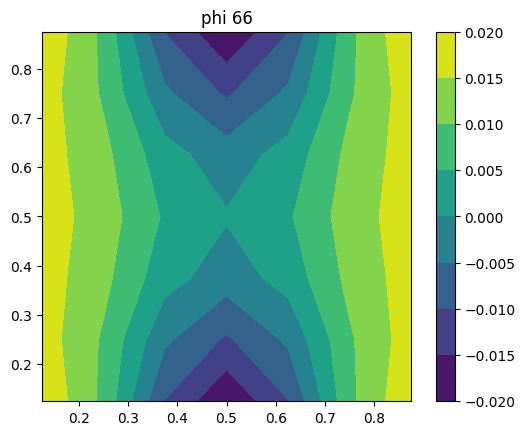

i 67
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


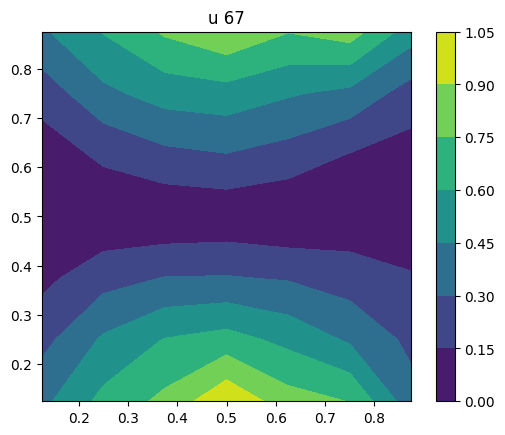

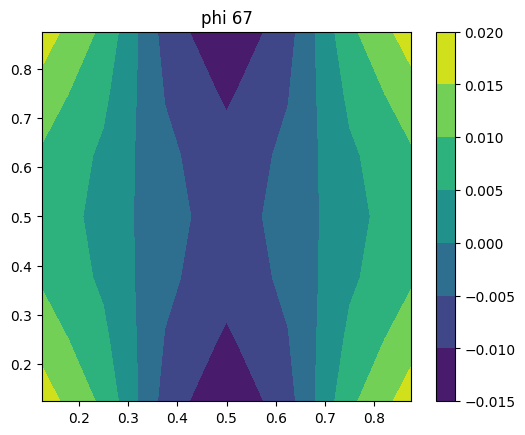

i 68
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


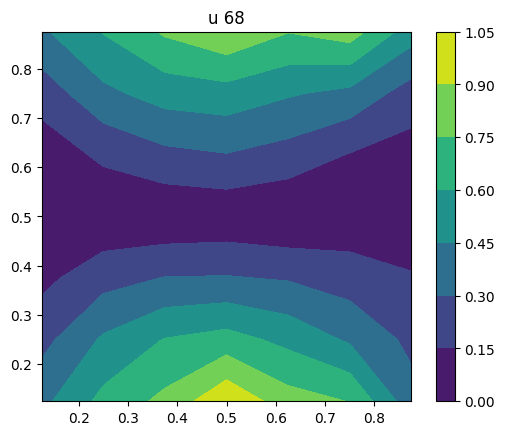

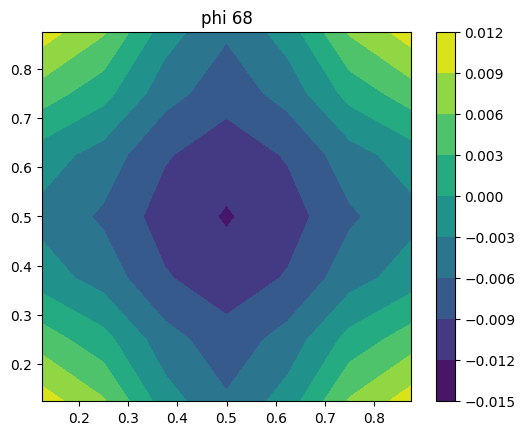

i 69
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


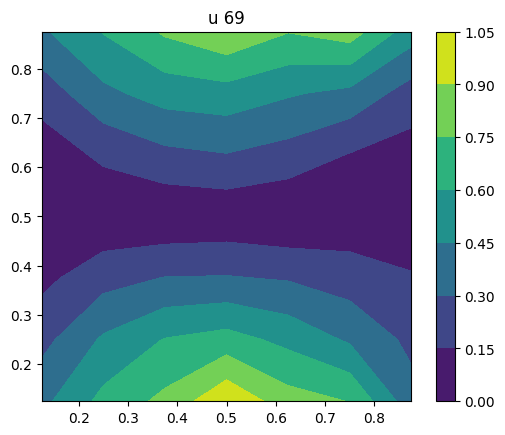

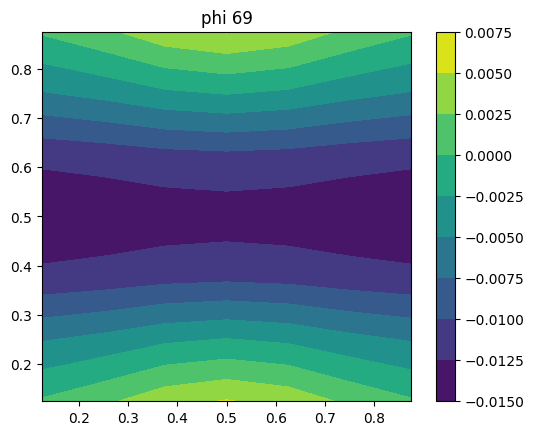

i 70
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


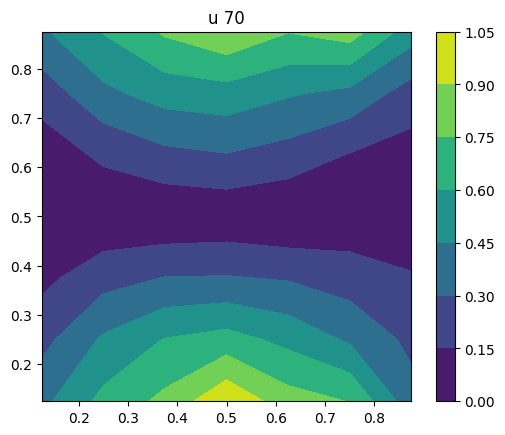

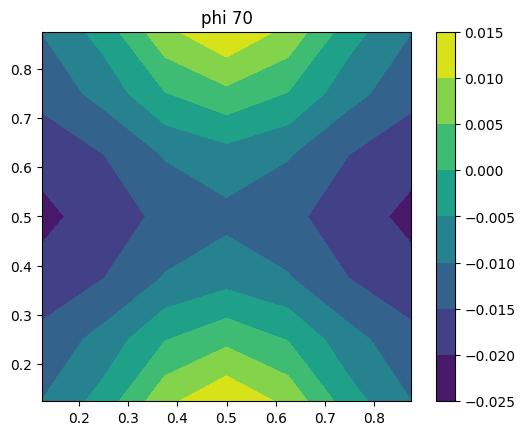

i 71
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


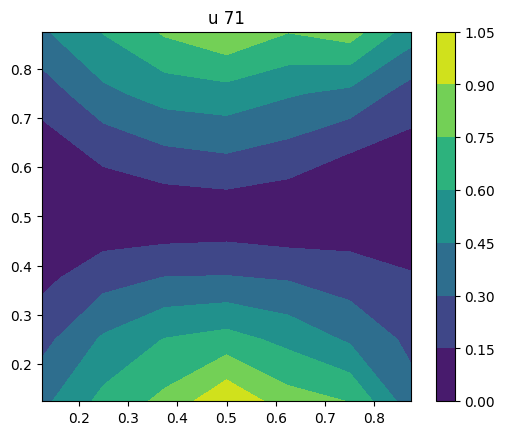

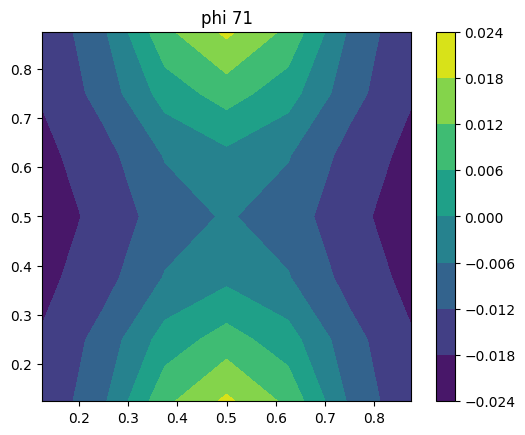

i 72
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


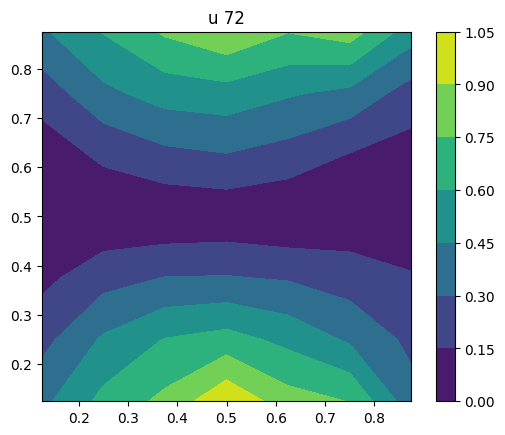

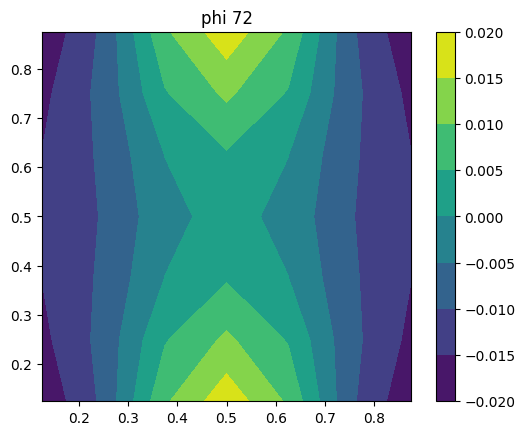

i 73
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


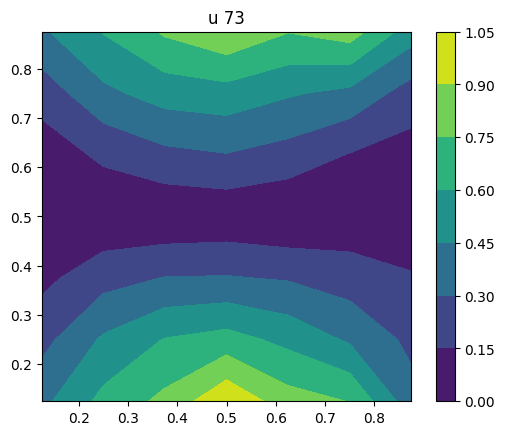

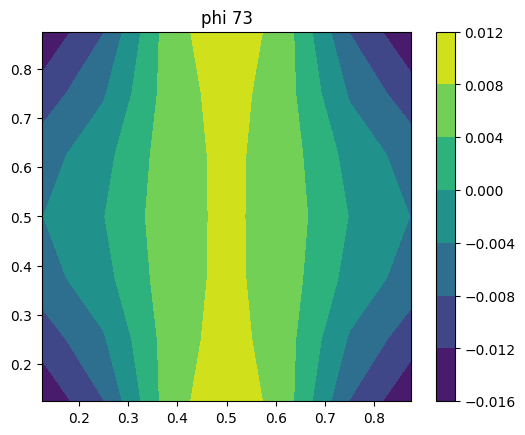

i 74
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


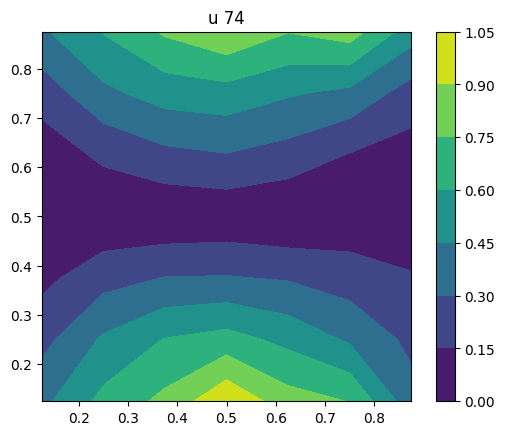

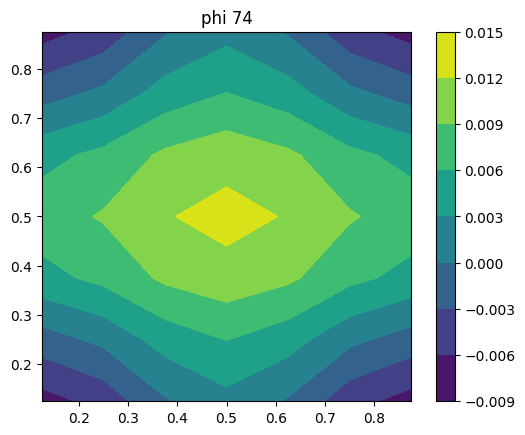

i 75
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


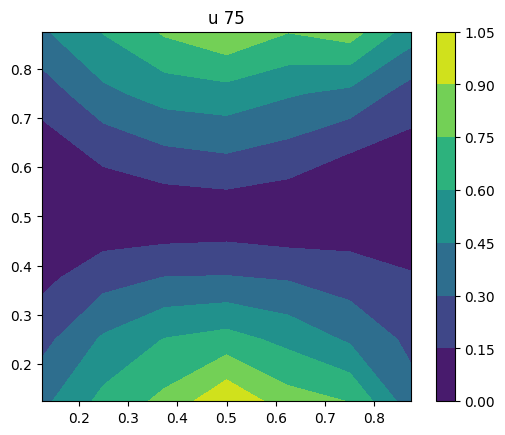

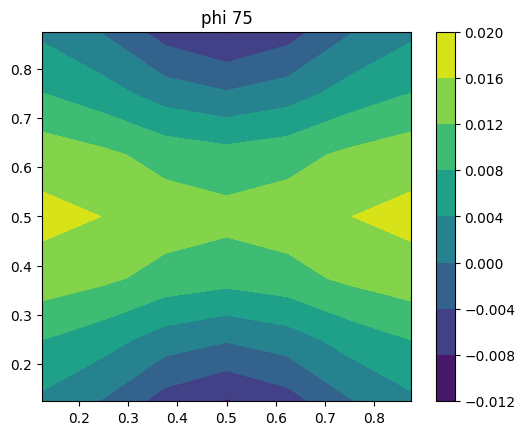

i 76
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


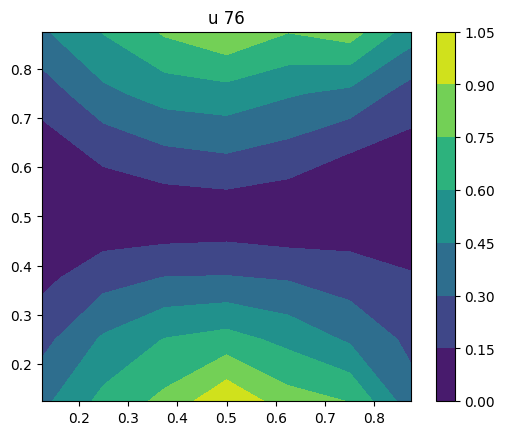

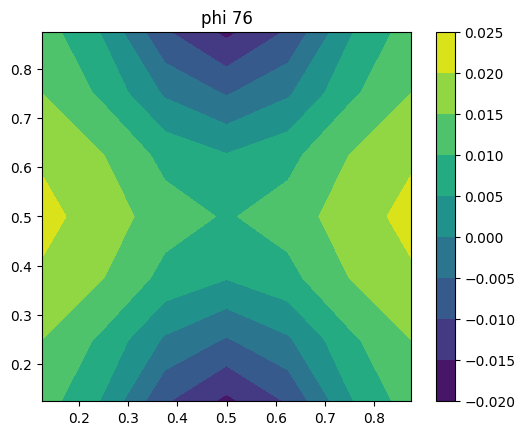

i 77
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


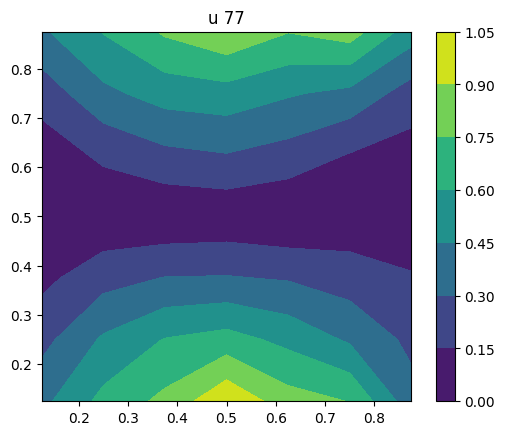

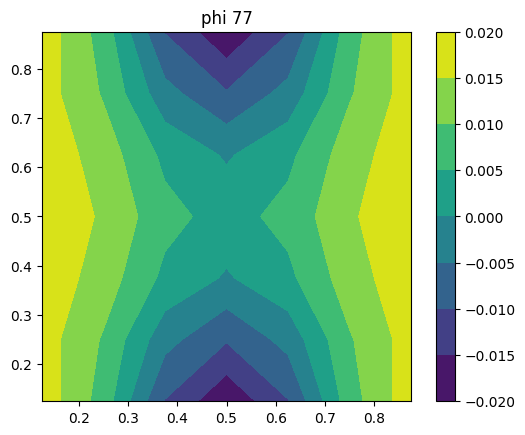

i 78
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


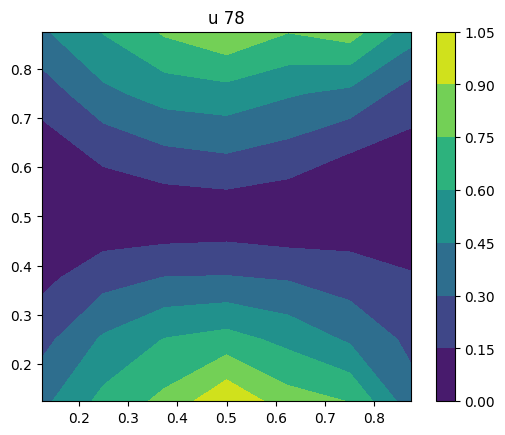

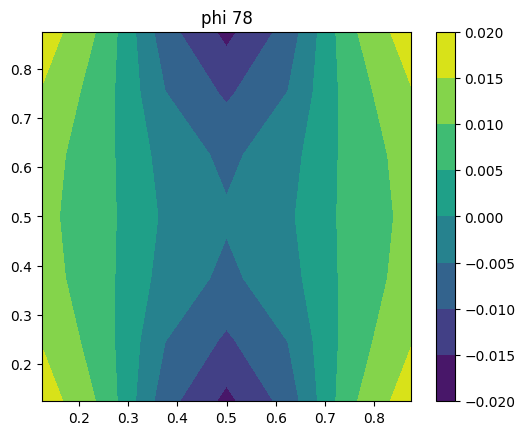

i 79
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


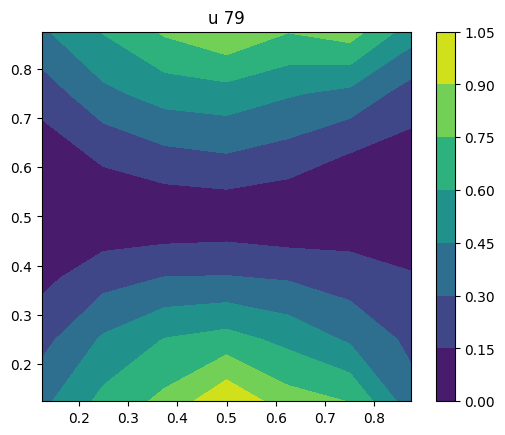

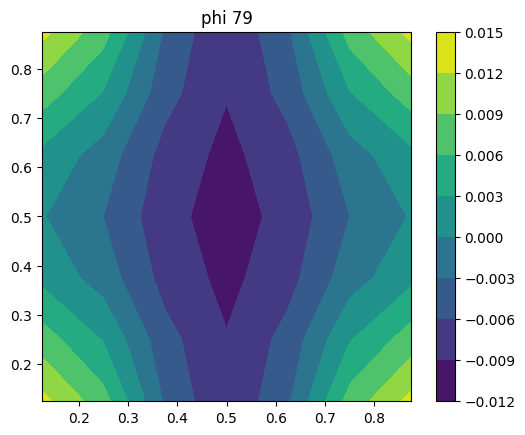

i 80
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


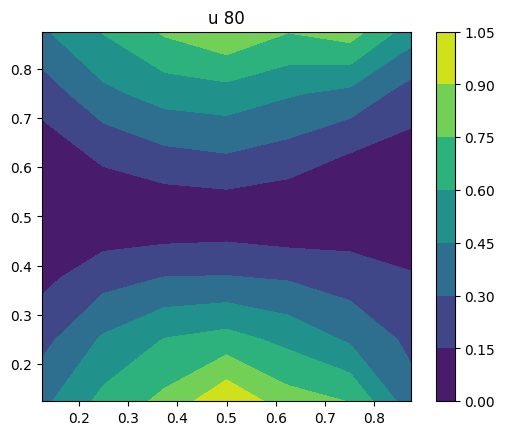

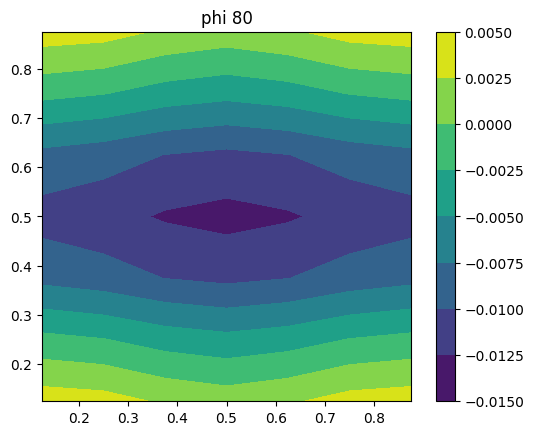

i 81
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


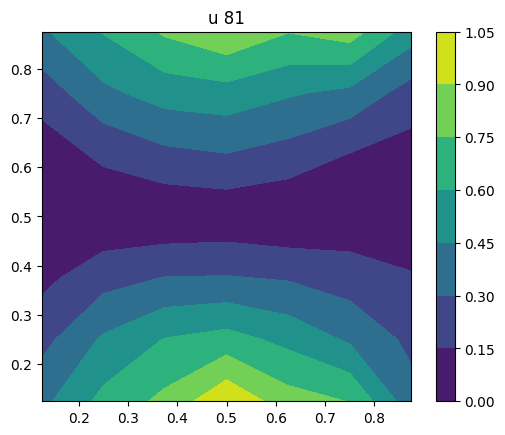

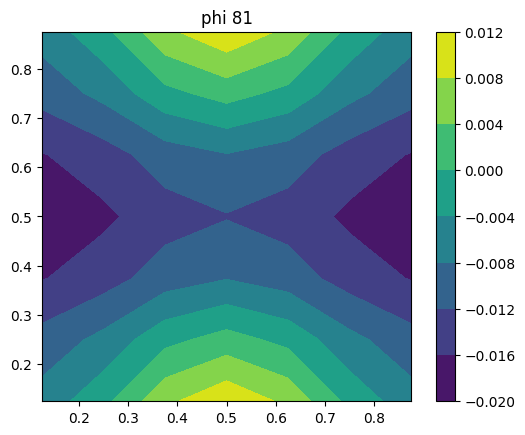

i 82
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


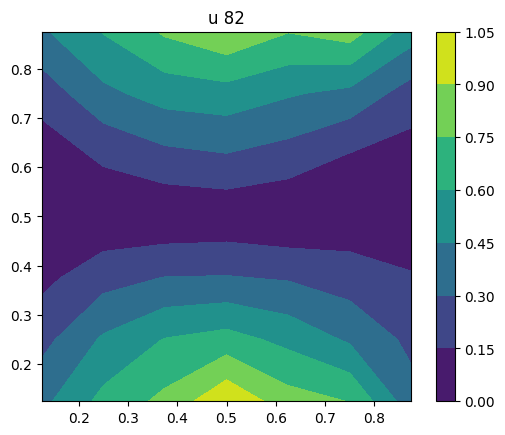

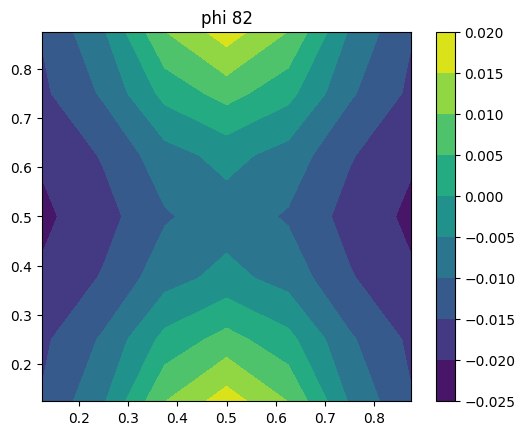

i 83
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


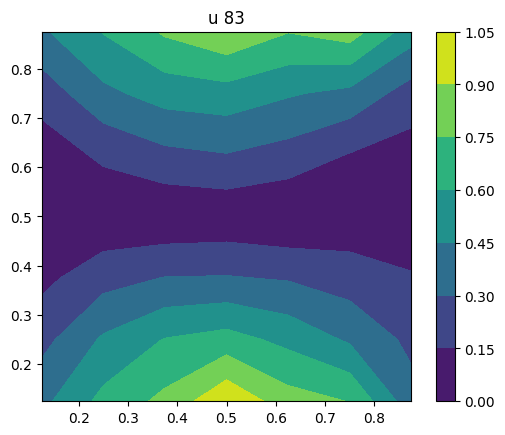

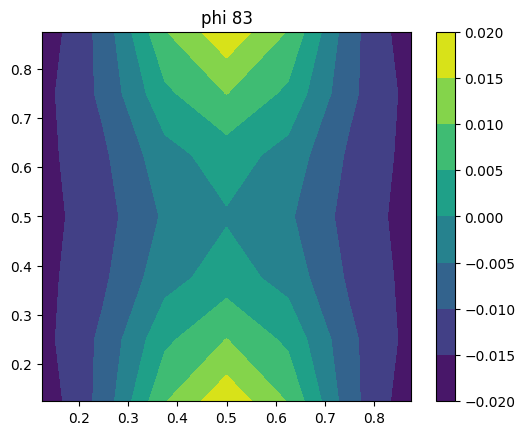

i 84
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


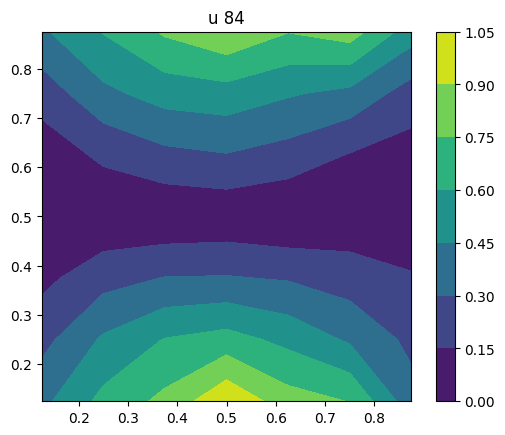

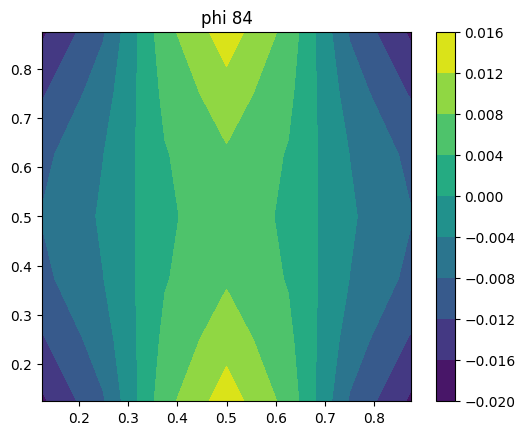

i 85
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


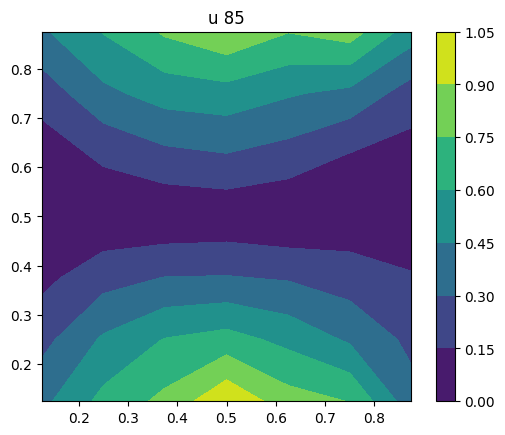

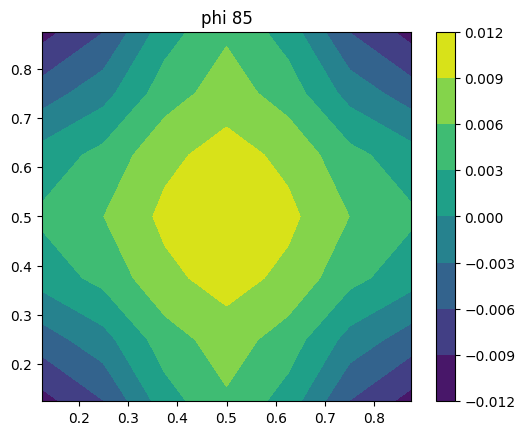

i 86
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


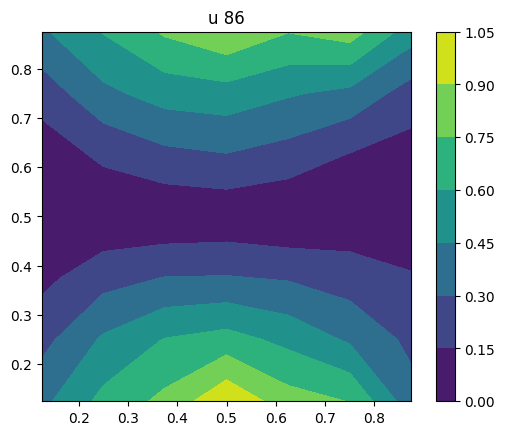

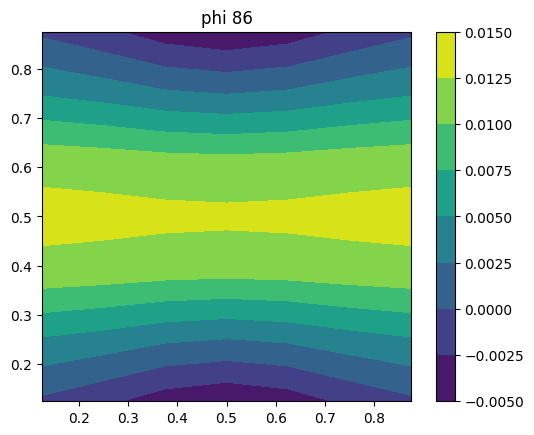

i 87
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


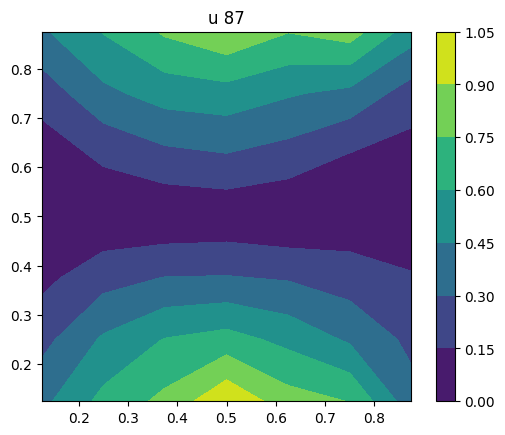

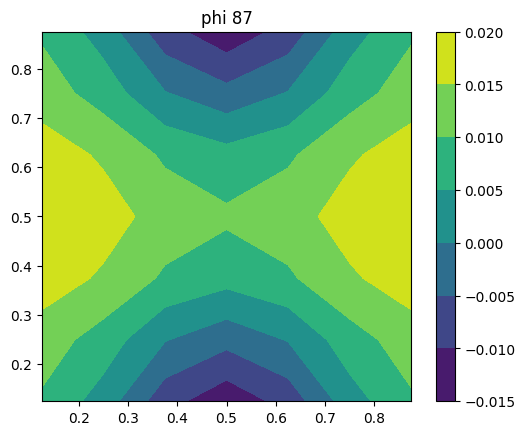

i 88
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


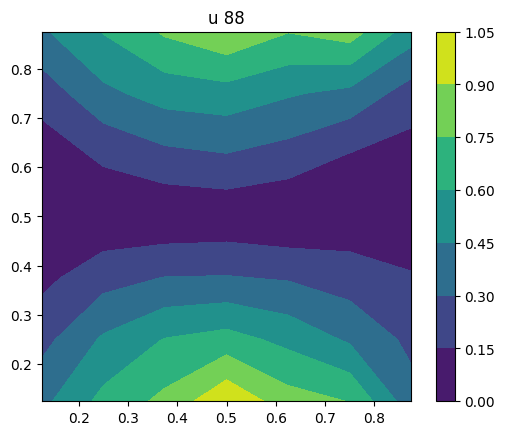

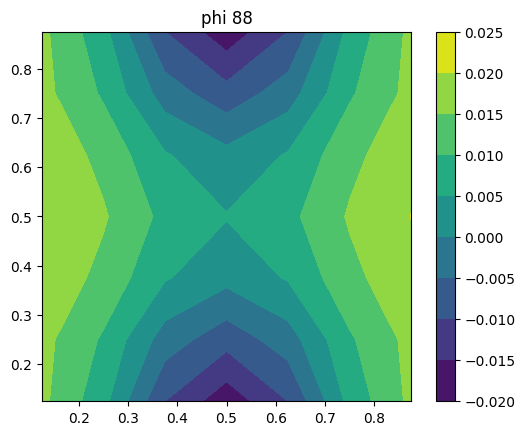

i 89
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


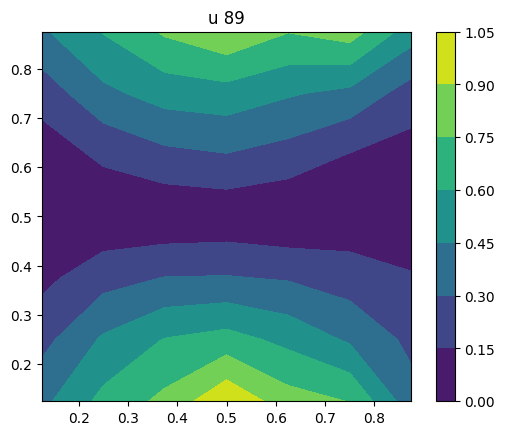

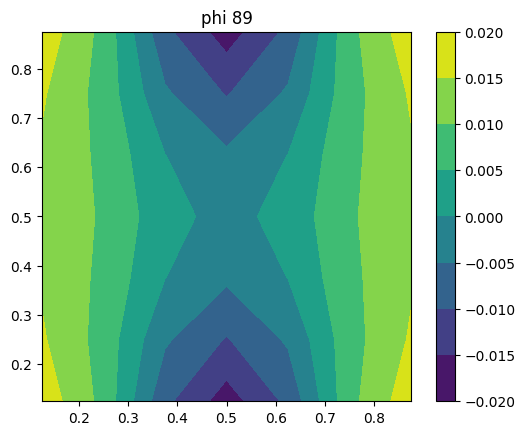

i 90
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


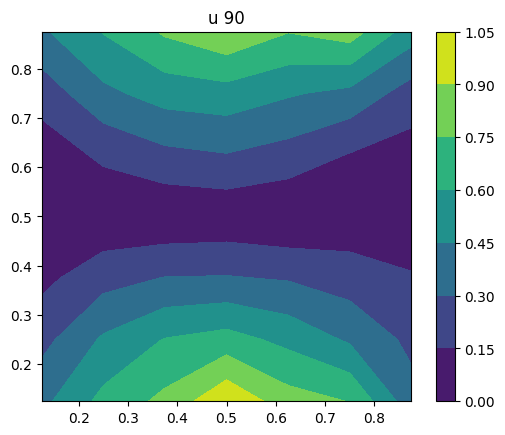

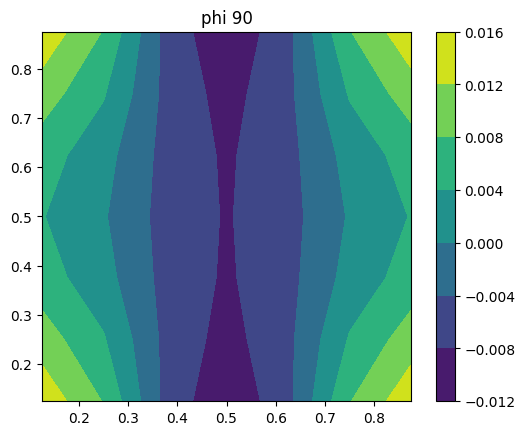

i 91
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


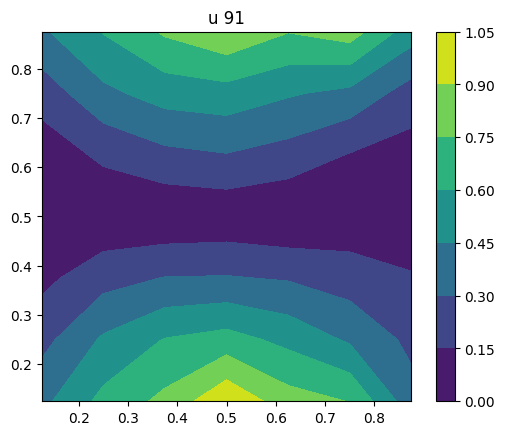

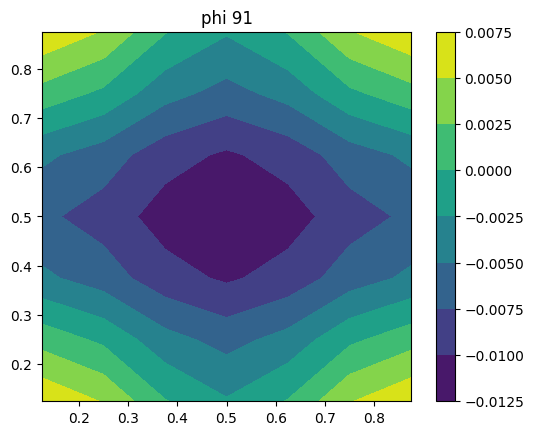

i 92
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


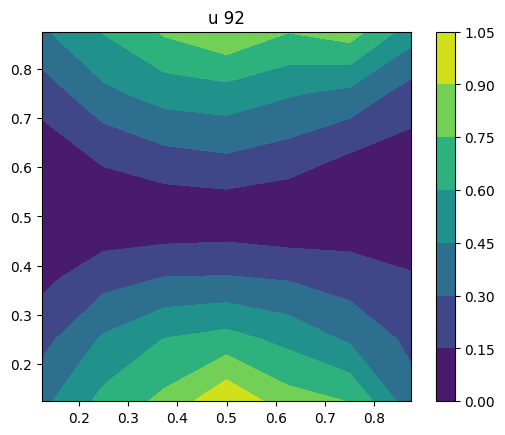

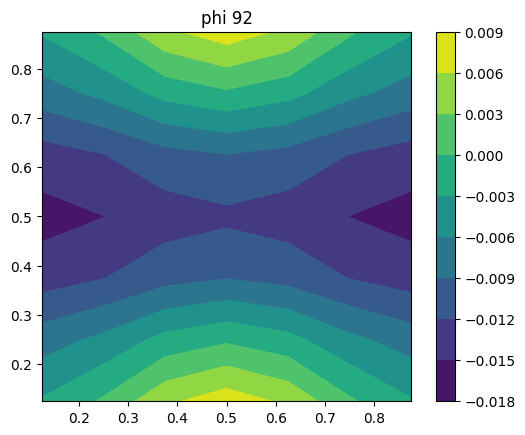

i 93
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


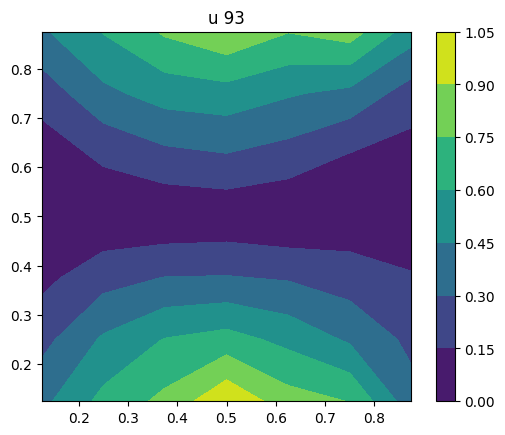

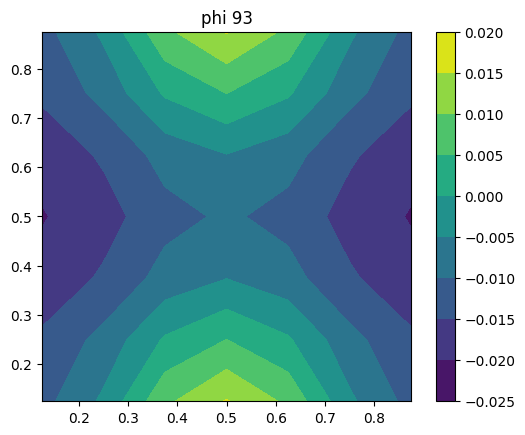

i 94
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


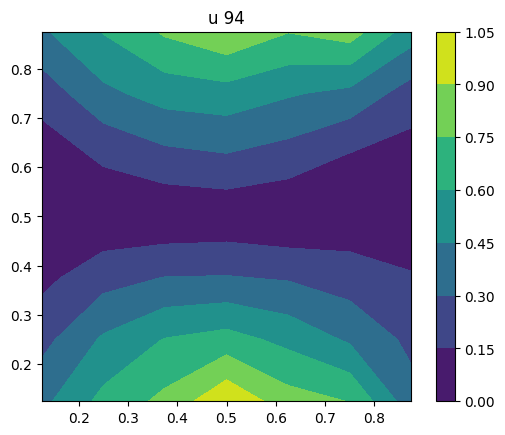

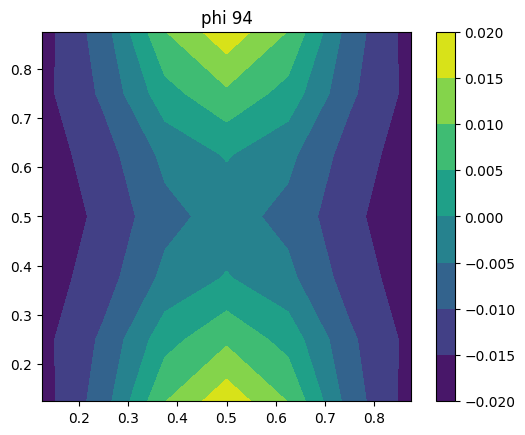

i 95
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


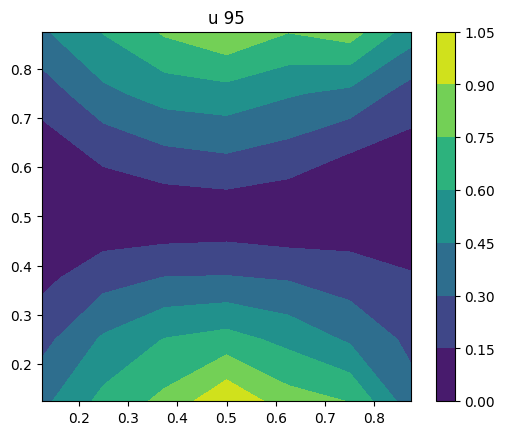

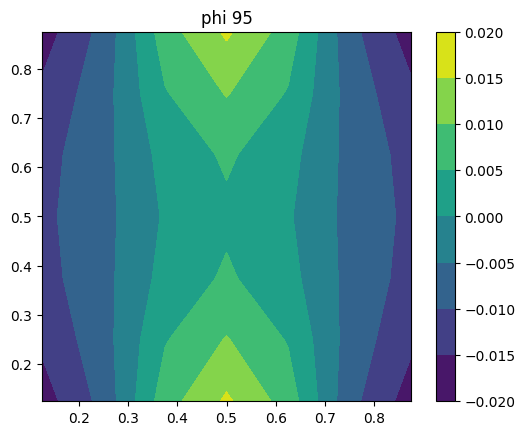

i 96
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


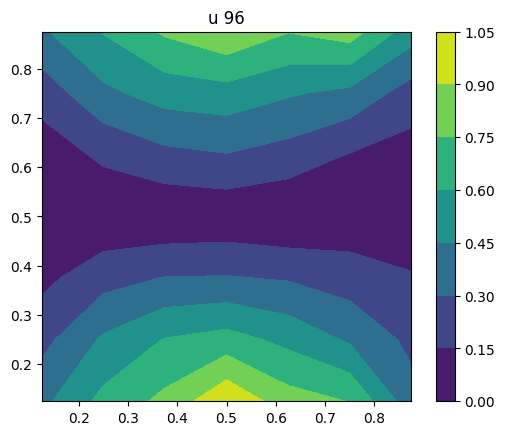

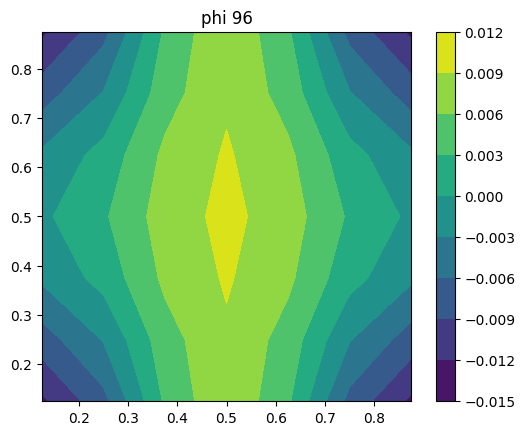

i 97
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


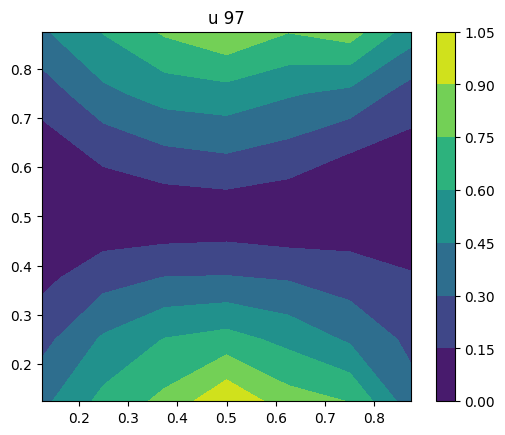

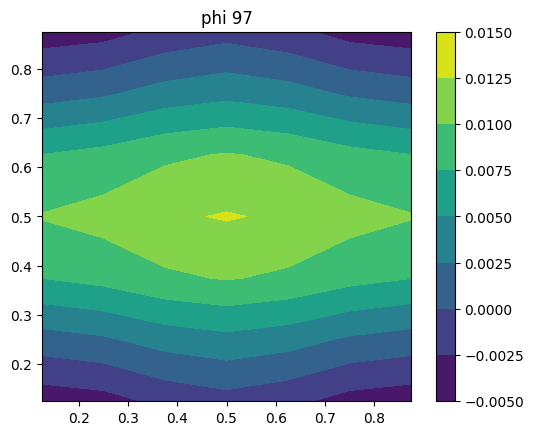

i 98
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


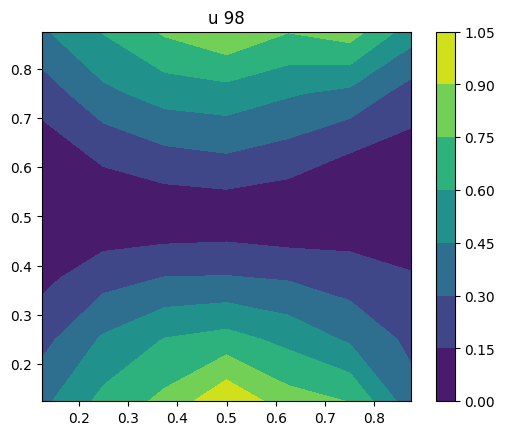

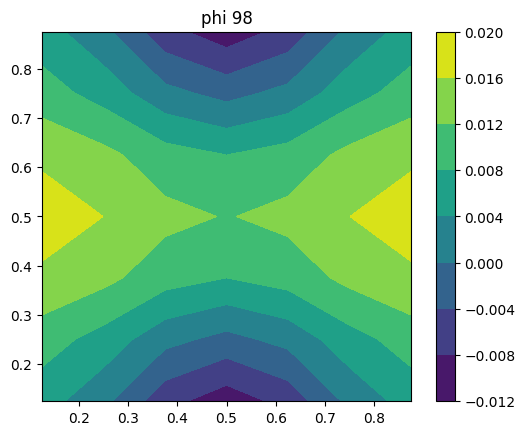

i 99
solve_u_hat:u_n shape: (2, 49)
solve_u_hat:u_n shape: (2, 49)
u_hat shape (2, 49)


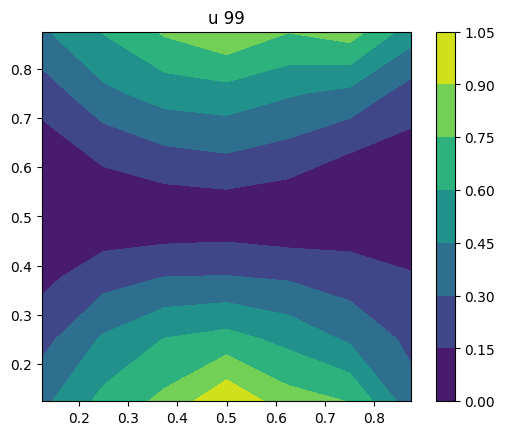

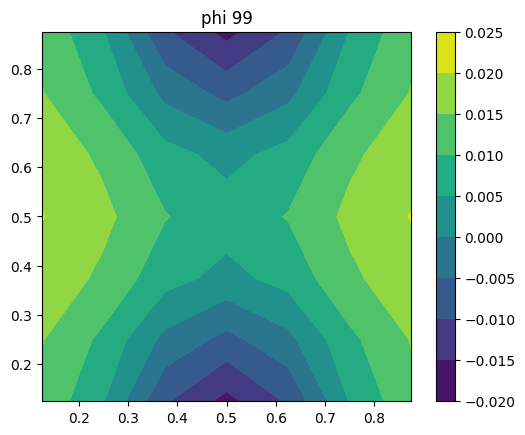

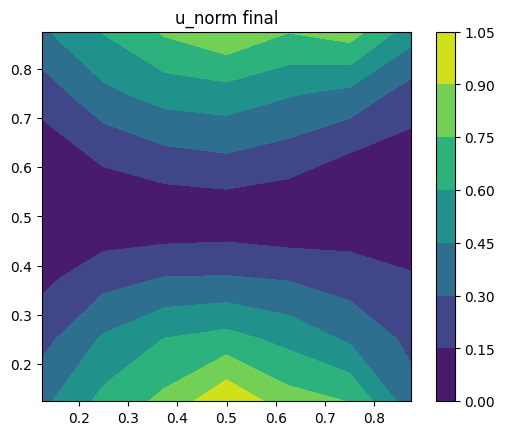

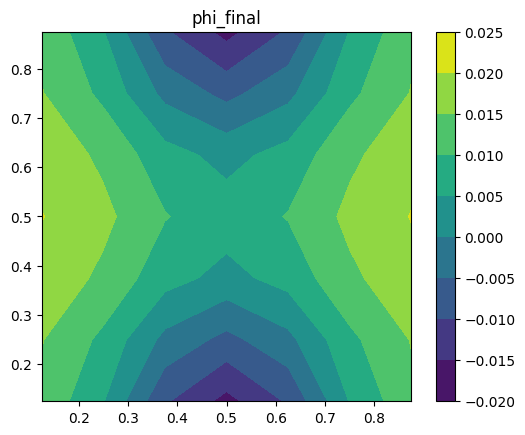

In [97]:
plotting(m-1, delta_x, delta_t, t_e, T, x_mod, y_mod, eta, rho, epsilon, M, C0)